# Concept

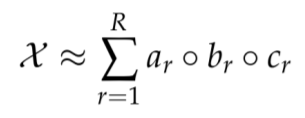

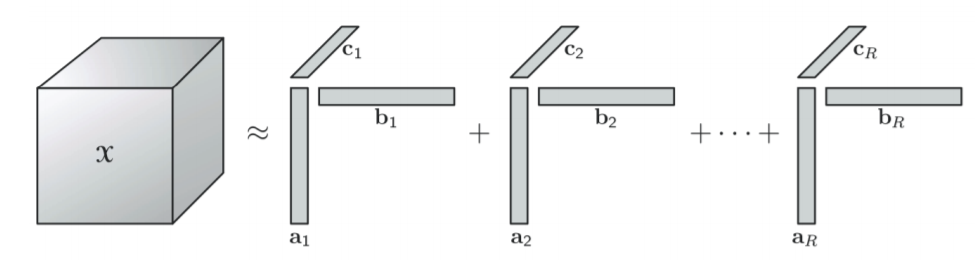

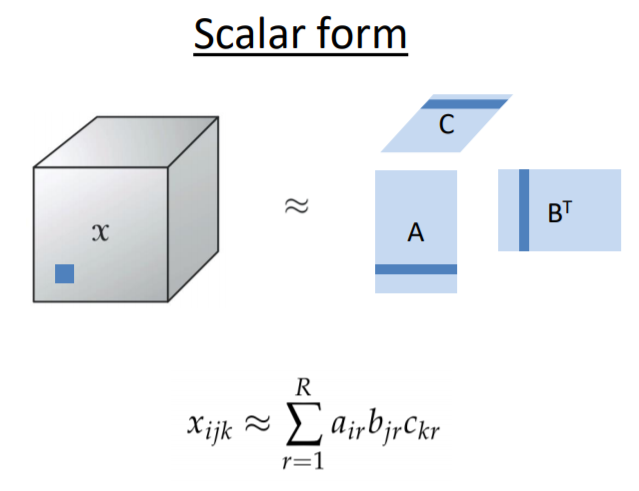

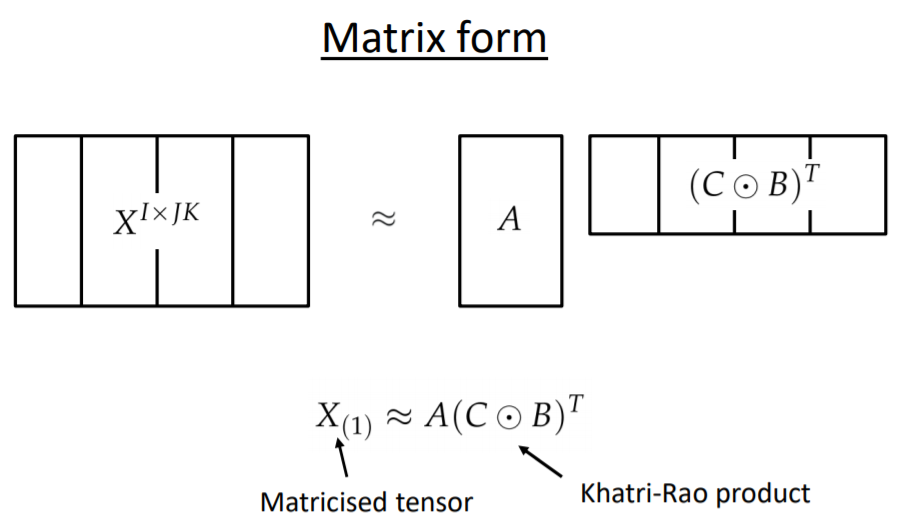

# Model estimation

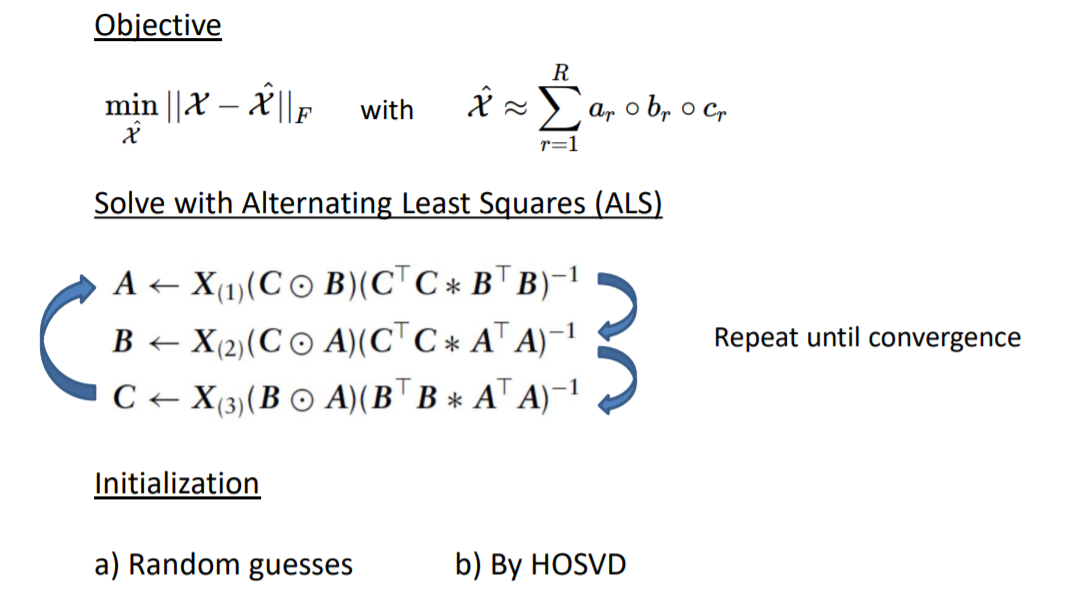

# Baseline with tensorly

In [5]:
from tensorly.decomposition import parafac,non_negative_parafac
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_test = pd.read_csv('./Testing Data/K036VRÁS-RS211.csv',index_col=0)
df_test.index = pd.DatetimeIndex(df_test.CTime)
df_test = df_test.loc[df_test.OkPct >= 98]
df_test = df_test.loc[df_test.Flag == 524480]


In [6]:
x = df_test.loc[(df_test.CType == 4) & (df_test.Val > 0),:].Val
x = x.resample('1h').mean()
x = x.fillna(method='ffill')
weekhour_index = x.index.weekday * 24 + x.index.hour
first_0 = np.argwhere(weekhour_index == 0)[0,0]
last_0 = np.argwhere(weekhour_index == 0)[-1,0]
x = x.iloc[first_0:last_0]
X = x.values.reshape((-1,7,24))

In [11]:
(core_tesnor,loadings),errors = non_negative_parafac(X,
                                                     rank=3,
                                                     n_iter_max = 10000,
                                                     tol=1e-10,
                                                     return_errors=True,
                                                     fixed_modes=[])
l_weeks,l_days,l_hours = loadings

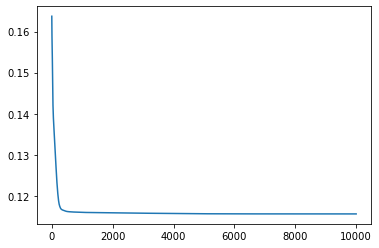

In [12]:
plt.plot(errors)

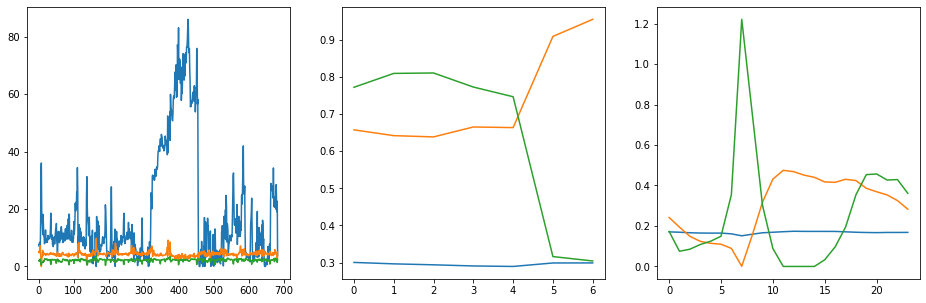

In [13]:
f,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(l_weeks)
ax[1].plot(l_days)
ax[2].plot(l_hours)
plt.show()

# Attempt number 1. Implementation of ALS

In [1]:
import tensorly as tl
from tensorly.random import check_random_state
from tensorly.kruskal_tensor import (kruskal_to_tensor, KruskalTensor,
                              unfolding_dot_khatri_rao, kruskal_norm,
                              kruskal_normalise)

In [15]:
def initialize_kruskal_custom(tensor,
                       rank,
                       init='random',
                       svd='numpy_svd',
                       random_state=None, 
                       non_negative=False,
                       normalize_factors=False,
                       flat_factors = []):

    rng = check_random_state(random_state)
    
    if init == 'mixed random':
        factors = [tl.tensor(rng.random_sample((tensor.shape[i], rank)), **tl.context(tensor)) for i in range(tl.ndim(tensor))]
        for mode,factor in flat_factors:
            factors[mode][:,factor] = np.ones(factors[mode][:,-1].shape)
            
#         print(factors)
        kt = KruskalTensor((None, factors))
    
    if init == 'random':
        factors = [tl.tensor(rng.random_sample((tensor.shape[i], rank)), **tl.context(tensor)) for i in range(tl.ndim(tensor))]
        kt = KruskalTensor((None, factors))

        
    if non_negative:
        kt.factors = [tl.abs(f) for f in kt[1]]

    if normalize_factors:
        kt = kruskal_normalise(kt)

    return kt

In [16]:
def error_calc(tensor, norm_tensor, weights, factors, sparsity, mask, mttkrp=None):

    # ||tensor - rec||^2 = ||tensor||^2 + ||rec||^2 - 2*<tensor, rec>
    factors_norm = kruskal_norm((weights, factors))

    # mttkrp and factor for the last mode. This is equivalent to the
    # inner product <tensor, factorization>
    iprod = tl.sum(tl.sum(mttkrp*factors[-1], axis=0)*weights)
    unnorml_rec_error = tl.sqrt(tl.abs(norm_tensor**2 + factors_norm**2 - 2*iprod))

    return unnorml_rec_error, tensor, norm_tensor

In [25]:
# Arugments
tensor = X
rng = check_random_state(None)
rank = 3
n_iter_max = 10000
flat_factors = [(1,2),(2,2)]
verbose = 1
tol = 1e-10
cvg_criterion = 'abs_rec_error'
fixed_modes = []

# Initialization
weights, factors = initialize_kruskal_custom(tensor, rank=rank,init='mixed random', flat_factors = flat_factors )
original_factors = factors.copy()


In [26]:
rec_errors = []
norm_tensor = tl.norm(tensor, 2)
Id = tl.eye(rank, **tl.context(tensor))

tl.ndim(tensor)-1 in fixed_modes

modes_list = [mode for mode in range(tl.ndim(tensor)) if mode not in fixed_modes]

In [27]:
for iteration in range(n_iter_max):

    if verbose > 1:
        print("Starting iteration", iteration + 1)
        
    for mode in modes_list:
        if verbose > 1:
            print("Mode", mode, "of", tl.ndim(tensor))

        pseudo_inverse = tl.tensor(np.ones((rank, rank)), **tl.context(tensor))
        for i, factor in enumerate(factors):
            if i != mode:
                pseudo_inverse = pseudo_inverse*tl.dot(tl.conj(tl.transpose(factor)), factor)
        pseudo_inverse += Id

        mttkrp = unfolding_dot_khatri_rao(tensor, (None, factors), mode)
        factor = tl.transpose(tl.solve(tl.conj(tl.transpose(pseudo_inverse)),
                                tl.transpose(mttkrp)))

#         if normalize_factors:
#             scales = tl.norm(factor, 2, axis=0)
#             weights = tl.where(scales==0, tl.ones(tl.shape(scales), **tl.context(factor)), scales)
#             factor = factor / tl.reshape(weights, (1, -1))

        factors[mode] = factor
    
    # Re-flatten flat factors
    if len(flat_factors) > 0:
        for mode,factor in flat_factors:
            factors[mode][:,factor] = np.ones(factors[mode][:,factor].shape)

    # Calculate the current unnormalized error if we need it
    if tol and False is False:
        unnorml_rec_error, tensor, norm_tensor = error_calc(tensor, norm_tensor, weights, factors, False, None, mttkrp)
    else:
        if mask is not None:
            tensor = tensor*mask + tl.kruskal_to_tensor((weights, factors), mask=1-mask)


    if tol:
        rec_error = unnorml_rec_error / norm_tensor
        rec_errors.append(rec_error)

        if iteration >= 1:
            rec_error_decrease = rec_errors[-2] - rec_errors[-1]

            if verbose:
                print("iteration {}, reconstruction error: {}, decrease = {}, unnormalized = {}".format(iteration, rec_error, rec_error_decrease, unnorml_rec_error))

            if cvg_criterion == 'abs_rec_error':
                stop_flag = abs(rec_error_decrease) < tol
            elif cvg_criterion == 'rec_error':
                stop_flag =  rec_error_decrease < tol
            else:
                raise TypeError("Unknown convergence criterion")

            if stop_flag:
                if verbose:
                    print("PARAFAC converged after {} iterations".format(iteration))
                break

        else:
            if verbose:
                print('reconstruction error={}'.format(rec_errors[-1]))

kruskal_tensor = KruskalTensor((weights, factors))




reconstruction error=0.20010740938492355
iteration 1, reconstruction error: 0.21162650791761659, decrease = -0.011519098532693034, unnormalized = 179.55963370430695
iteration 2, reconstruction error: 0.0873429599656095, decrease = 0.12428354795200708, unnormalized = 74.10824878412717
iteration 3, reconstruction error: 0.06307510739920584, decrease = 0.024267852566403667, unnormalized = 53.51760179717271
iteration 4, reconstruction error: 0.04638181686367532, decrease = 0.016693290535530522, unnormalized = 39.35377533056438
iteration 5, reconstruction error: 0.036027135380656154, decrease = 0.010354681483019164, unnormalized = 30.56809515981996
iteration 6, reconstruction error: 0.030349926642680908, decrease = 0.0056772087379752464, unnormalized = 25.751129972025225
iteration 7, reconstruction error: 0.02835699204470299, decrease = 0.001992934597977919, unnormalized = 24.060176367343235
iteration 8, reconstruction error: 0.028893287602284722, decrease = -0.0005362955575817334, unnormal

iteration 109, reconstruction error: 0.038561172199549285, decrease = -6.146212939318885e-05, unnormalized = 32.71816004285818
iteration 110, reconstruction error: 0.03862478809481395, decrease = -6.361589526466399e-05, unnormalized = 32.77213648921121
iteration 111, reconstruction error: 0.03869051013384096, decrease = -6.572203902700802e-05, unnormalized = 32.827899944225
iteration 112, reconstruction error: 0.03875829068465827, decrease = -6.778055081731182e-05, unnormalized = 32.885409993399804
iteration 113, reconstruction error: 0.03882808246629491, decrease = -6.97917816366439e-05, unnormalized = 32.9446265200512
iteration 114, reconstruction error: 0.038899838802699885, decrease = -7.175633640497253e-05, unnormalized = 33.0055099207538
iteration 115, reconstruction error: 0.03897351377926782, decrease = -7.367497656793343e-05, unnormalized = 33.06802123814917
iteration 116, reconstruction error: 0.03904906231269436, decrease = -7.554853342654072e-05, unnormalized = 33.132122220

iteration 217, reconstruction error: 0.04743786077749323, decrease = -2.4452452892322063e-05, unnormalized = 40.24980135398969
iteration 218, reconstruction error: 0.04746079254048793, decrease = -2.2931762994699012e-05, unnormalized = 40.269258363435426
iteration 219, reconstruction error: 0.04748222183964303, decrease = -2.142929915509989e-05, unnormalized = 40.287440571064764
iteration 220, reconstruction error: 0.047502167458147136, decrease = -1.994561850410942e-05, unnormalized = 40.30436391392878
iteration 221, reconstruction error: 0.047520648702207985, decrease = -1.8481244060848667e-05, unnormalized = 40.320044772846785
iteration 222, reconstruction error: 0.047537685367535394, decrease = -1.7036665327409273e-05, unnormalized = 40.33449994396799
iteration 223, reconstruction error: 0.04755329770604115, decrease = -1.561233850575633e-05, unnormalized = 40.34774661051721
iteration 224, reconstruction error: 0.04756750639333881, decrease = -1.4208687297657951e-05, unnormalized =

iteration 283, reconstruction error: 0.046723944488853565, decrease = 3.008801984494963e-05, unnormalized = 39.644061796383895
iteration 284, reconstruction error: 0.04669365069849265, decrease = 3.0293790360916284e-05, unnormalized = 39.618358296599084
iteration 285, reconstruction error: 0.04666316351907607, decrease = 3.0487179416581467e-05, unnormalized = 39.59249071118842
iteration 286, reconstruction error: 0.04663249503287877, decrease = 3.0668486197295286e-05, unnormalized = 39.566469291650584
iteration 287, reconstruction error: 0.0466016570258604, decrease = 3.0838007018370306e-05, unnormalized = 39.540304038068335
iteration 288, reconstruction error: 0.04657066099083531, decrease = 3.099603502509235e-05, unnormalized = 39.51400470179824
iteration 289, reconstruction error: 0.04653951813068316, decrease = 3.114286015214879e-05, unnormalized = 39.48758078819475
iteration 290, reconstruction error: 0.04650823936170359, decrease = 3.127876897957016e-05, unnormalized = 39.4610415

iteration 402, reconstruction error: 0.04340757522552328, decrease = 2.035497773509448e-05, unnormalized = 36.8302080121329
iteration 403, reconstruction error: 0.043387352475417994, decrease = 2.0222750105283738e-05, unnormalized = 36.81304953025306
iteration 404, reconstruction error: 0.04336726118591741, decrease = 2.0091289500583087e-05, unnormalized = 36.79600258930568
iteration 405, reconstruction error: 0.0433473005841915, decrease = 1.9960601725911575e-05, unnormalized = 36.77906653356441
iteration 406, reconstruction error: 0.04332746989217134, decrease = 1.9830692020161855e-05, unnormalized = 36.762240702857845
iteration 407, reconstruction error: 0.043307768326945065, decrease = 1.9701565226272477e-05, unnormalized = 36.74552443290546
iteration 408, reconstruction error: 0.04328819510110263, decrease = 1.9573225842436925e-05, unnormalized = 36.72891705561014
iteration 409, reconstruction error: 0.04326874942332085, decrease = 1.9445677781775028e-05, unnormalized = 36.7124178

iteration 516, reconstruction error: 0.041764376714327915, decrease = 1.0047998868362162e-05, unnormalized = 35.435996456704494
iteration 517, reconstruction error: 0.04175438431242188, decrease = 9.992401906036563e-06, unnormalized = 35.427518161410916
iteration 518, reconstruction error: 0.04174444706604417, decrease = 9.937246377711428e-06, unnormalized = 35.41908666416055
iteration 519, reconstruction error: 0.04173456453758413, decrease = 9.8825284600354e-06, unnormalized = 35.41070159365206
iteration 520, reconstruction error: 0.04172473629326482, decrease = 9.82824431931123e-06, unnormalized = 35.40236258183687
iteration 521, reconstruction error: 0.041714961903091125, decrease = 9.774390173696024e-06, unnormalized = 35.39406926387523
iteration 522, reconstruction error: 0.04170524094075901, decrease = 9.720962332114558e-06, unnormalized = 35.38582127805917
iteration 523, reconstruction error: 0.04169557298377783, decrease = 9.667956981179726e-06, unnormalized = 35.3776182659162

iteration 628, reconstruction error: 0.04090823571811278, decrease = 5.8620934888092835e-06, unnormalized = 34.7095829029758
iteration 629, reconstruction error: 0.04090239750055242, decrease = 5.838217560359682e-06, unnormalized = 34.70462932595494
iteration 630, reconstruction error: 0.040896582988420416, decrease = 5.814512132003291e-06, unnormalized = 34.69969586237864
iteration 631, reconstruction error: 0.040890792012490136, decrease = 5.790975930279607e-06, unnormalized = 34.69478236866245
iteration 632, reconstruction error: 0.04088502440486555, decrease = 5.767607624586335e-06, unnormalized = 34.689888702350935
iteration 633, reconstruction error: 0.0408792799988962, decrease = 5.744405969350386e-06, unnormalized = 34.685014722045466
iteration 634, reconstruction error: 0.040873558629210646, decrease = 5.7213696855532015e-06, unnormalized = 34.68016028743265
iteration 635, reconstruction error: 0.040867860131714326, decrease = 5.698497496320343e-06, unnormalized = 34.675325259

iteration 695, reconstruction error: 0.04056226148319231, decrease = 4.585590327725597e-06, unnormalized = 34.416032688001636
iteration 696, reconstruction error: 0.04055769070450207, decrease = 4.570778690239641e-06, unnormalized = 34.412154500172335
iteration 697, reconstruction error: 0.040553134631511424, decrease = 4.556072990644089e-06, unnormalized = 34.408288789749854
iteration 698, reconstruction error: 0.04054859315899247, decrease = 4.541472518951317e-06, unnormalized = 34.40443546745103
iteration 699, reconstruction error: 0.040544066182432066, decrease = 4.526976560406681e-06, unnormalized = 34.40059444459916
iteration 700, reconstruction error: 0.04053955359793685, decrease = 4.5125844952143e-06, unnormalized = 34.396765633043394
iteration 701, reconstruction error: 0.0405350553023018, decrease = 4.498295635049776e-06, unnormalized = 34.39294894521694
iteration 702, reconstruction error: 0.040530571193062824, decrease = 4.484109238978018e-06, unnormalized = 34.38914429418

iteration 809, reconstruction error: 0.04011452366319603, decrease = 3.4422769241912454e-06, unnormalized = 34.03613869577362
iteration 810, reconstruction error: 0.040111087583613855, decrease = 3.4360795821766765e-06, unnormalized = 34.033223270871396
iteration 811, reconstruction error: 0.04010765765018543, decrease = 3.42993342842407e-06, unnormalized = 34.0303130608221
iteration 812, reconstruction error: 0.04010423381205694, decrease = 3.423838128492618e-06, unnormalized = 34.027408022477594
iteration 813, reconstruction error: 0.040100816018733464, decrease = 3.4177933234749713e-06, unnormalized = 34.02450811299424
iteration 814, reconstruction error: 0.0400974042200752, decrease = 3.4117986582662962e-06, unnormalized = 34.021613289829695
iteration 815, reconstruction error: 0.040093998366225035, decrease = 3.405853850162177e-06, unnormalized = 34.018723510681504
iteration 816, reconstruction error: 0.04009059840770159, decrease = 3.3999585234423257e-06, unnormalized = 34.015838

iteration 897, reconstruction error: 0.03983083399888078, decrease = 3.0586577519434166e-06, unnormalized = 33.79543533251643
iteration 898, reconstruction error: 0.03982777818940609, decrease = 3.055809474690474e-06, unnormalized = 33.7928425569925
iteration 899, reconstruction error: 0.039824725201955354, decrease = 3.052987450735678e-06, unnormalized = 33.7902521758831
iteration 900, reconstruction error: 0.039821675010396546, decrease = 3.0501915588079798e-06, unnormalized = 33.78766416701588
iteration 901, reconstruction error: 0.03981862758895048, decrease = 3.0474214460646243e-06, unnormalized = 33.78507850851789
iteration 902, reconstruction error: 0.03981558291198385, decrease = 3.044676966629245e-06, unnormalized = 33.78249517863991
iteration 903, reconstruction error: 0.03981254095406207, decrease = 3.0419579217788595e-06, unnormalized = 33.77991415580136
iteration 904, reconstruction error: 0.03980950169005501, decrease = 3.0392640070625587e-06, unnormalized = 33.7773354186

iteration 1004, reconstruction error: 0.03951574325878962, decrease = 2.863524094093295e-06, unnormalized = 33.52808896635888
iteration 1005, reconstruction error: 0.039512880842520165, decrease = 2.8624162694557143e-06, unnormalized = 33.525660279981594
iteration 1006, reconstruction error: 0.039510019526007634, decrease = 2.861316512531298e-06, unnormalized = 33.52323252671969
iteration 1007, reconstruction error: 0.03950715930129243, decrease = 2.8602247152051397e-06, unnormalized = 33.520805699819654
iteration 1008, reconstruction error: 0.039504300160482106, decrease = 2.8591408103226246e-06, unnormalized = 33.51837979258496
iteration 1009, reconstruction error: 0.03950144209587837, decrease = 2.858064603733501e-06, unnormalized = 33.5159547984838
iteration 1010, reconstruction error: 0.039498585099837925, decrease = 2.856996040447035e-06, unnormalized = 33.513530711031024
iteration 1011, reconstruction error: 0.03949572916480933, decrease = 2.8559350285922713e-06, unnormalized = 

iteration 1114, reconstruction error: 0.03920630649308694, decrease = 2.7701166016996792e-06, unnormalized = 33.265539851642835
iteration 1115, reconstruction error: 0.039203537108352504, decrease = 2.7693847344384404e-06, unnormalized = 33.263190100123545
iteration 1116, reconstruction error: 0.03920076845540119, decrease = 2.76865295131129e-06, unnormalized = 33.260840969503356
iteration 1117, reconstruction error: 0.03919800053412816, decrease = 2.7679212730308267e-06, unnormalized = 33.25849245969332
iteration 1118, reconstruction error: 0.03919523334444912, decrease = 2.7671896790440464e-06, unnormalized = 33.25614457062192
iteration 1119, reconstruction error: 0.039192466886337506, decrease = 2.766458111612413e-06, unnormalized = 33.25379730226661
iteration 1120, reconstruction error: 0.03918970115979143, decrease = 2.765726546075098e-06, unnormalized = 33.25145065462579
iteration 1121, reconstruction error: 0.03918693616487089, decrease = 2.764994920537167e-06, unnormalized = 33

iteration 1239, reconstruction error: 0.03886601270769279, decrease = 2.6724233282982013e-06, unnormalized = 32.97680935158179
iteration 1240, reconstruction error: 0.03886334114812432, decrease = 2.6715595684706495e-06, unnormalized = 32.97454260219272
iteration 1241, reconstruction error: 0.03886067045379212, decrease = 2.6706943321991305e-06, unnormalized = 32.972276586934306
iteration 1242, reconstruction error: 0.038858000626181305, decrease = 2.669827610816966e-06, unnormalized = 32.970011307066635
iteration 1243, reconstruction error: 0.03885533166672742, decrease = 2.6689594538817363e-06, unnormalized = 32.967746763807725
iteration 1244, reconstruction error: 0.038852663576853824, decrease = 2.6680898735989556e-06, unnormalized = 32.965482958365264
iteration 1245, reconstruction error: 0.0388499963580009, decrease = 2.6672188529267005e-06, unnormalized = 32.96321989196137
iteration 1246, reconstruction error: 0.03884733001161765, decrease = 2.666346383246865e-06, unnormalized =

iteration 1344, reconstruction error: 0.03859046884840495, decrease = 2.5748819878698703e-06, unnormalized = 32.743017493794035
iteration 1345, reconstruction error: 0.03858789494747926, decrease = 2.5739009256939283e-06, unnormalized = 32.740833605244546
iteration 1346, reconstruction error: 0.03858532202818924, decrease = 2.572919290018405e-06, unnormalized = 32.73865054958762
iteration 1347, reconstruction error: 0.03858275009124263, decrease = 2.571936946610398e-06, unnormalized = 32.73646832742373
iteration 1348, reconstruction error: 0.03858017913727178, decrease = 2.570953970847112e-06, unnormalized = 32.734286939289426
iteration 1349, reconstruction error: 0.03857760916692596, decrease = 2.569970345825401e-06, unnormalized = 32.73210638573558
iteration 1350, reconstruction error: 0.03857504018082094, decrease = 2.5689861050184892e-06, unnormalized = 32.72992666728467
iteration 1351, reconstruction error: 0.03857247217954328, decrease = 2.568001277659937e-06, unnormalized = 32.7

iteration 1456, reconstruction error: 0.03830838608793073, decrease = 2.46295036379629e-06, unnormalized = 32.50367754700075
iteration 1457, reconstruction error: 0.0383059241381019, decrease = 2.4619498288289132e-06, unnormalized = 32.501588646069514
iteration 1458, reconstruction error: 0.038303463188469056, decrease = 2.46094963284732e-06, unnormalized = 32.49950059377878
iteration 1459, reconstruction error: 0.0383010032388281, decrease = 2.4599496409524746e-06, unnormalized = 32.49741338995536
iteration 1460, reconstruction error: 0.03829854428889038, decrease = 2.4589499377225543e-06, unnormalized = 32.49532703435436
iteration 1461, reconstruction error: 0.038296086338346, decrease = 2.457950544383636e-06, unnormalized = 32.49324152671283
iteration 1462, reconstruction error: 0.038293629386914406, decrease = 2.4569514315911367e-06, unnormalized = 32.491156866792736
iteration 1463, reconstruction error: 0.038291173434352975, decrease = 2.4559525614309408e-06, unnormalized = 32.489

iteration 1570, reconstruction error: 0.03803406652091009, decrease = 2.3518078379747287e-06, unnormalized = 32.2709244696248
iteration 1571, reconstruction error: 0.03803171565327122, decrease = 2.350867638868659e-06, unnormalized = 32.26892981906672
iteration 1572, reconstruction error: 0.038029365725138375, decrease = 2.349928132847068e-06, unnormalized = 32.26693596565527
iteration 1573, reconstruction error: 0.0380270167357757, decrease = 2.3489893626743585e-06, unnormalized = 32.264942908766095
iteration 1574, reconstruction error: 0.03802466868448537, decrease = 2.3480512903323314e-06, unnormalized = 32.26295064780711
iteration 1575, reconstruction error: 0.038022321570565044, decrease = 2.3471139203243285e-06, unnormalized = 32.2609591821824
iteration 1576, reconstruction error: 0.038019975393244115, decrease = 2.346177320929066e-06, unnormalized = 32.258968511238116
iteration 1577, reconstruction error: 0.03801763015184528, decrease = 2.3452413988322984e-06, unnormalized = 32.

iteration 1688, reconstruction error: 0.037762948711171265, decrease = 2.246094274710453e-06, unnormalized = 32.04088800072286
iteration 1689, reconstruction error: 0.03776070346668231, decrease = 2.2452444889548007e-06, unnormalized = 32.03898296868325
iteration 1690, reconstruction error: 0.03775845907122703, decrease = 2.244395455278103e-06, unnormalized = 32.03707865702682
iteration 1691, reconstruction error: 0.03775621552403602, decrease = 2.2435471910137172e-06, unnormalized = 32.03517506510074
iteration 1692, reconstruction error: 0.03775397282431818, decrease = 2.2426997178387476e-06, unnormalized = 32.03327219223379
iteration 1693, reconstruction error: 0.03775173097135929, decrease = 2.2418529588910663e-06, unnormalized = 32.03137003781997
iteration 1694, reconstruction error: 0.03774948996434638, decrease = 2.2410070129111337e-06, unnormalized = 32.02946860116949
iteration 1695, reconstruction error: 0.037747249802500486, decrease = 2.2401618458914307e-06, unnormalized = 32

iteration 1802, reconstruction error: 0.037512280359981706, decrease = 2.1539580606980135e-06, unnormalized = 31.82820236996822
iteration 1803, reconstruction error: 0.037510127170136257, decrease = 2.1531898454496545e-06, unnormalized = 31.826375443919357
iteration 1804, reconstruction error: 0.03750797474784507, decrease = 2.152422291186451e-06, unnormalized = 31.82454916912049
iteration 1805, reconstruction error: 0.03750582309245992, decrease = 2.151655385147777e-06, unnormalized = 31.822723545021613
iteration 1806, reconstruction error: 0.03750367220335822, decrease = 2.1508891017013587e-06, unnormalized = 31.82089857109448
iteration 1807, reconstruction error: 0.03750152207985685, decrease = 2.1501235013682285e-06, unnormalized = 31.81907424675948
iteration 1808, reconstruction error: 0.03749937272135442, decrease = 2.149358502435972e-06, unnormalized = 31.817250571506346
iteration 1809, reconstruction error: 0.03749722412717601, decrease = 2.148594178408292e-06, unnormalized = 3

iteration 1918, reconstruction error: 0.037267474715362424, decrease = 2.0688581899852565e-06, unnormalized = 31.620491094527733
iteration 1919, reconstruction error: 0.03726540655840883, decrease = 2.068156953596856e-06, unnormalized = 31.618736316694438
iteration 1920, reconstruction error: 0.037263339102183456, decrease = 2.0674562253714113e-06, unnormalized = 31.61698213341097
iteration 1921, reconstruction error: 0.03726127234615198, decrease = 2.066756031475492e-06, unnormalized = 31.615228544223967
iteration 1922, reconstruction error: 0.03725920628978425, decrease = 2.0660563677318833e-06, unnormalized = 31.613475548683603
iteration 1923, reconstruction error: 0.037257140932701854, decrease = 2.065357082393915e-06, unnormalized = 31.611723146468815
iteration 1924, reconstruction error: 0.03725507627429623, decrease = 2.0646584056246975e-06, unnormalized = 31.60997133706324
iteration 1925, reconstruction error: 0.037253012314075816, decrease = 2.063960220413663e-06, unnormalized

iteration 2032, reconstruction error: 0.03703610358321367, decrease = 1.9919322500130954e-06, unnormalized = 31.42417865641599
iteration 2033, reconstruction error: 0.03703411230097578, decrease = 1.9912822378925776e-06, unnormalized = 31.422489104796224
iteration 2034, reconstruction error: 0.03703212166833523, decrease = 1.990632640551382e-06, unnormalized = 31.420800104343048
iteration 2035, reconstruction error: 0.037030131684894586, decrease = 1.9899834406422734e-06, unnormalized = 31.41911165471925
iteration 2036, reconstruction error: 0.0370281423502825, decrease = 1.989334612088889e-06, unnormalized = 31.417423755609743
iteration 2037, reconstruction error: 0.03702615366406634, decrease = 1.9886862161547225e-06, unnormalized = 31.415736406647465
iteration 2038, reconstruction error: 0.03702416562590512, decrease = 1.988038161225558e-06, unnormalized = 31.414049607543078
iteration 2039, reconstruction error: 0.03702217823533976, decrease = 1.987390565359737e-06, unnormalized = 3

iteration 2145, reconstruction error: 0.03681511147603785, decrease = 1.920820610699925e-06, unnormalized = 31.236672553298323
iteration 2146, reconstruction error: 0.036813191265143784, decrease = 1.9202108940685747e-06, unnormalized = 31.23504330388072
iteration 2147, reconstruction error: 0.03681127166358731, decrease = 1.919601556474304e-06, unnormalized = 31.23341457147035
iteration 2148, reconstruction error: 0.03680935267109036, decrease = 1.9189924969492678e-06, unnormalized = 31.23178635583128
iteration 2149, reconstruction error: 0.03680743428733082, decrease = 1.9183837595415643e-06, unnormalized = 31.230158656690197
iteration 2150, reconstruction error: 0.03680551651198209, decrease = 1.91777534872678e-06, unnormalized = 31.228531473769998
iteration 2151, reconstruction error: 0.03680359934470869, decrease = 1.9171672734005774e-06, unnormalized = 31.22690480678603
iteration 2152, reconstruction error: 0.036801682785214576, decrease = 1.916559494115344e-06, unnormalized = 31

iteration 2259, reconstruction error: 0.0366000587992603, decrease = 1.8532604166843214e-06, unnormalized = 31.054205903683993
iteration 2260, reconstruction error: 0.036598206115153735, decrease = 1.8526841065666377e-06, unnormalized = 31.052633949003937
iteration 2261, reconstruction error: 0.0365963540070427, decrease = 1.852108111037587e-06, unnormalized = 31.051062483041232
iteration 2262, reconstruction error: 0.03659450247464346, decrease = 1.851532399239908e-06, unnormalized = 31.04949150555514
iteration 2263, reconstruction error: 0.03659265151776059, decrease = 1.8509568828692369e-06, unnormalized = 31.04792101637984
iteration 2264, reconstruction error: 0.036590801136114605, decrease = 1.8503816459833344e-06, unnormalized = 31.04635101527821
iteration 2265, reconstruction error: 0.03658895132942597, decrease = 1.8498066886377118e-06, unnormalized = 31.04478150201305
iteration 2266, reconstruction error: 0.03658710209740619, decrease = 1.8492320197766032e-06, unnormalized = 3

iteration 2386, reconstruction error: 0.03636929117866067, decrease = 1.7820971446938505e-06, unnormalized = 30.858405529555927
iteration 2387, reconstruction error: 0.03636750962656263, decrease = 1.7815520980402066e-06, unnormalized = 30.856893928550477
iteration 2388, reconstruction error: 0.03636572861926675, decrease = 1.7810072958784895e-06, unnormalized = 30.855382789795602
iteration 2389, reconstruction error: 0.03636394815651955, decrease = 1.7804627472015055e-06, unnormalized = 30.853872113076235
iteration 2390, reconstruction error: 0.03636216823815198, decrease = 1.7799183675698549e-06, unnormalized = 30.852361898248947
iteration 2391, reconstruction error: 0.03636038886391487, decrease = 1.7793742371069454e-06, unnormalized = 30.850852145102326
iteration 2392, reconstruction error: 0.03635861003356345, decrease = 1.7788303514204573e-06, unnormalized = 30.849342853428677
iteration 2393, reconstruction error: 0.03635683174687065, decrease = 1.7782866928023333e-06, unnormaliz

iteration 2503, reconstruction error: 0.036164489735106914, decrease = 1.7197975006946753e-06, unnormalized = 30.68463678693253
iteration 2504, reconstruction error: 0.03616277045784942, decrease = 1.7192772574919912e-06, unnormalized = 30.68317802452309
iteration 2505, reconstruction error: 0.036161051700712585, decrease = 1.7187571368371124e-06, unnormalized = 30.68171970342261
iteration 2506, reconstruction error: 0.03615933346343963, decrease = 1.7182372729560025e-06, unnormalized = 30.680261823413222
iteration 2507, reconstruction error: 0.03615761574583185, decrease = 1.7177176077770584e-06, unnormalized = 30.678804384326337
iteration 2508, reconstruction error: 0.036155898547677076, decrease = 1.7171981547756121e-06, unnormalized = 30.677347385981932
iteration 2509, reconstruction error: 0.036154181868861476, decrease = 1.7166788155997814e-06, unnormalized = 30.675890828283414
iteration 2510, reconstruction error: 0.036152465709069874, decrease = 1.7161597916023896e-06, unnormal

iteration 2609, reconstruction error: 0.03598510342683353, decrease = 1.6657109826942462e-06, unnormalized = 30.532432131088207
iteration 2610, reconstruction error: 0.03598343821627694, decrease = 1.6652105565909125e-06, unnormalized = 30.531019242879992
iteration 2611, reconstruction error: 0.035981773505928294, decrease = 1.6647103486464032e-06, unnormalized = 30.52960677908532
iteration 2612, reconstruction error: 0.03598010929565479, decrease = 1.6642102735053843e-06, unnormalized = 30.528194739591505
iteration 2613, reconstruction error: 0.03597844558525164, decrease = 1.6637104031519412e-06, unnormalized = 30.526783124224796
iteration 2614, reconstruction error: 0.035976782374523, decrease = 1.6632107286349007e-06, unnormalized = 30.525371932819024
iteration 2615, reconstruction error: 0.03597511966333141, decrease = 1.6627111915912263e-06, unnormalized = 30.523961165257553
iteration 2616, reconstruction error: 0.03597345745148991, decrease = 1.6622118415021703e-06, unnormalized

iteration 2722, reconstruction error: 0.03580005966446134, decrease = 1.6102488412869653e-06, unnormalized = 30.375427271357914
iteration 2723, reconstruction error: 0.03579844989700187, decrease = 1.6097674594706124e-06, unnormalized = 30.37406142518762
iteration 2724, reconstruction error: 0.035796840610758766, decrease = 1.6092862431052457e-06, unnormalized = 30.372695987317005
iteration 2725, reconstruction error: 0.03579523180559365, decrease = 1.6088051651153013e-06, unnormalized = 30.37133095762865
iteration 2726, reconstruction error: 0.03579362348131386, decrease = 1.608324279790685e-06, unnormalized = 30.3699663359591
iteration 2727, reconstruction error: 0.035792015637799005, decrease = 1.6078435148558778e-06, unnormalized = 30.368602122206187
iteration 2728, reconstruction error: 0.03579040827489247, decrease = 1.6073629065319062e-06, unnormalized = 30.367238316237042
iteration 2729, reconstruction error: 0.0357888013924105, decrease = 1.6068824819706617e-06, unnormalized =

iteration 2842, reconstruction error: 0.035610279855622436, decrease = 1.5535845366218548e-06, unnormalized = 30.214403998352562
iteration 2843, reconstruction error: 0.035608726734240904, decrease = 1.5531213815311862e-06, unnormalized = 30.21308621491839
iteration 2844, reconstruction error: 0.035607174075911574, decrease = 1.5526583293304363e-06, unnormalized = 30.211768824372065
iteration 2845, reconstruction error: 0.035605621880408896, decrease = 1.5521955026784329e-06, unnormalized = 30.210451826522217
iteration 2846, reconstruction error: 0.03560407014767077, decrease = 1.551732738122591e-06, unnormalized = 30.20913522131616
iteration 2847, reconstruction error: 0.035602518877521534, decrease = 1.551270149238726e-06, unnormalized = 30.207819008604837
iteration 2848, reconstruction error: 0.035600968069812694, decrease = 1.5508077088402517e-06, unnormalized = 30.206503188262268
iteration 2849, reconstruction error: 0.035599417724441175, decrease = 1.5503453715190463e-06, unnorma

iteration 2953, reconstruction error: 0.03544067879903434, decrease = 1.503030228333646e-06, unnormalized = 30.070501876182327
iteration 2954, reconstruction error: 0.03543917621657103, decrease = 1.5025824633141394e-06, unnormalized = 30.06922697371676
iteration 2955, reconstruction error: 0.03543767408178366, decrease = 1.5021347873692137e-06, unnormalized = 30.06795245109269
iteration 2956, reconstruction error: 0.03543617239453296, decrease = 1.5016872507017665e-06, unnormalized = 30.066678308191932
iteration 2957, reconstruction error: 0.03543467115466587, decrease = 1.501239867085502e-06, unnormalized = 30.065404544884643
iteration 2958, reconstruction error: 0.03543317036207043, decrease = 1.5007925954421686e-06, unnormalized = 30.0641311610758
iteration 2959, reconstruction error: 0.03543167001658895, decrease = 1.5003454814782602e-06, unnormalized = 30.062858156631627
iteration 2960, reconstruction error: 0.03543017011813218, decrease = 1.499898456769344e-06, unnormalized = 30

iteration 3074, reconstruction error: 0.03526207886747737, decrease = 1.449786165189093e-06, unnormalized = 29.91896444069968
iteration 3075, reconstruction error: 0.035260629513693756, decrease = 1.4493537836141046e-06, unnormalized = 29.917734701395965
iteration 3076, reconstruction error: 0.03525918059213865, decrease = 1.4489215551041768e-06, unnormalized = 29.916505328826997
iteration 3077, reconstruction error: 0.0352577321026452, decrease = 1.4484894934538306e-06, unnormalized = 29.91527632285119
iteration 3078, reconstruction error: 0.03525628404519326, decrease = 1.4480574519401546e-06, unnormalized = 29.91404768345147
iteration 3079, reconstruction error: 0.03525483641960673, decrease = 1.447625586528667e-06, unnormalized = 29.912819410478413
iteration 3080, reconstruction error: 0.03525338922573699, decrease = 1.4471938697413478e-06, unnormalized = 29.91159150380591
iteration 3081, reconstruction error: 0.035251942463508754, decrease = 1.4467622282340886e-06, unnormalized = 

iteration 3140, reconstruction error: 0.03516734310163917, decrease = 1.4215103154094355e-06, unnormalized = 29.838583586807662
iteration 3141, reconstruction error: 0.0351659220157882, decrease = 1.4210858509736135e-06, unnormalized = 29.83737783211571
iteration 3142, reconstruction error: 0.03516450135420938, decrease = 1.4206615788214805e-06, unnormalized = 29.836172437407736
iteration 3143, reconstruction error: 0.035163081116797786, decrease = 1.4202374115923622e-06, unnormalized = 29.834967402594714
iteration 3144, reconstruction error: 0.03516166130351744, decrease = 1.4198132803483476e-06, unnormalized = 29.833762727646114
iteration 3145, reconstruction error: 0.03516024191410236, decrease = 1.4193894150790753e-06, unnormalized = 29.832558412336265
iteration 3146, reconstruction error: 0.0351588229485993, decrease = 1.418965503055536e-06, unnormalized = 29.831354456704833
iteration 3147, reconstruction error: 0.035157404406765215, decrease = 1.4185418340875722e-06, unnormalized

iteration 3256, reconstruction error: 0.0350052978894146, decrease = 1.3730462439381919e-06, unnormalized = 29.70109240369979
iteration 3257, reconstruction error: 0.035003925254329125, decrease = 1.3726350854767477e-06, unnormalized = 29.69992775823272
iteration 3258, reconstruction error: 0.03500255303034423, decrease = 1.3722239848926177e-06, unnormalized = 29.698763461573893
iteration 3259, reconstruction error: 0.035001181217323464, decrease = 1.371813020768775e-06, unnormalized = 29.697599513607525
iteration 3260, reconstruction error: 0.034999809815167295, decrease = 1.3714021561694878e-06, unnormalized = 29.696435914249175
iteration 3261, reconstruction error: 0.03499843882373459, decrease = 1.3709914327073025e-06, unnormalized = 29.695272663379086
iteration 3262, reconstruction error: 0.034997068242976576, decrease = 1.3705807580116636e-06, unnormalized = 29.694109760955886
iteration 3263, reconstruction error: 0.03499569807274282, decrease = 1.3701702337581834e-06, unnormaliz

iteration 3372, reconstruction error: 0.03484878652739227, decrease = 1.3260713697671456e-06, unnormalized = 29.568296549759637
iteration 3373, reconstruction error: 0.03484746085475795, decrease = 1.3256726343197078e-06, unnormalized = 29.56717175072112
iteration 3374, reconstruction error: 0.03484613558076536, decrease = 1.3252739925889712e-06, unnormalized = 29.56604728991983
iteration 3375, reconstruction error: 0.03484481070526507, decrease = 1.3248755002873147e-06, unnormalized = 29.56492316722898
iteration 3376, reconstruction error: 0.03484348622820972, decrease = 1.324477055350548e-06, unnormalized = 29.563799382608384
iteration 3377, reconstruction error: 0.03484216214944054, decrease = 1.3240787691826128e-06, unnormalized = 29.562675935923327
iteration 3378, reconstruction error: 0.034840838468896185, decrease = 1.3236805443544997e-06, unnormalized = 29.561552827121766
iteration 3379, reconstruction error: 0.03483951518647351, decrease = 1.3232824226730444e-06, unnormalized 

iteration 3484, reconstruction error: 0.03470276553706099, decrease = 1.282052566144165e-06, unnormalized = 29.44440150563203
iteration 3485, reconstruction error: 0.034701483871854816, decrease = 1.2816652061736766e-06, unnormalized = 29.443314045761255
iteration 3486, reconstruction error: 0.0347002025938092, decrease = 1.2812780456131212e-06, unnormalized = 29.442226914386236
iteration 3487, reconstruction error: 0.034698921702873836, decrease = 1.2808909353664855e-06, unnormalized = 29.44114011146427
iteration 3488, reconstruction error: 0.034697641199007694, decrease = 1.2805038661425905e-06, unnormalized = 29.440053636960563
iteration 3489, reconstruction error: 0.03469636108196467, decrease = 1.2801170430204456e-06, unnormalized = 29.438967490666293
iteration 3490, reconstruction error: 0.034695081351810896, decrease = 1.2797301537775807e-06, unnormalized = 29.43788167263757
iteration 3491, reconstruction error: 0.03469380200835611, decrease = 1.2793434547853089e-06, unnormalize

iteration 3599, reconstruction error: 0.03455788788436752, decrease = 1.2381552326468093e-06, unnormalized = 29.321476554001176
iteration 3600, reconstruction error: 0.034556650105222214, decrease = 1.2377791453049847e-06, unnormalized = 29.320426330321144
iteration 3601, reconstruction error: 0.03455541270209705, decrease = 1.2374031251663475e-06, unnormalized = 29.319376425684496
iteration 3602, reconstruction error: 0.03455417567485456, decrease = 1.2370272424871986e-06, unnormalized = 29.31832683997461
iteration 3603, reconstruction error: 0.03455293902344153, decrease = 1.236651413029366e-06, unnormalized = 29.31727757314633
iteration 3604, reconstruction error: 0.03455170274777196, decrease = 1.2362756695721844e-06, unnormalized = 29.31622862512668
iteration 3605, reconstruction error: 0.034550466847727036, decrease = 1.2359000449227442e-06, unnormalized = 29.315179995814855
iteration 3606, reconstruction error: 0.034549231323192625, decrease = 1.2355245344111698e-06, unnormalize

iteration 3705, reconstruction error: 0.0344287575671208, decrease = 1.1988123792966432e-06, unnormalized = 29.21191281034214
iteration 3706, reconstruction error: 0.03442755912093744, decrease = 1.1984461833619564e-06, unnormalized = 29.210895959665844
iteration 3707, reconstruction error: 0.03442636104083325, decrease = 1.1980801041880373e-06, unnormalized = 29.209879419598284
iteration 3708, reconstruction error: 0.03442516332670554, decrease = 1.197714127709748e-06, unnormalized = 29.208863190052323
iteration 3709, reconstruction error: 0.034423965978503245, decrease = 1.197348202294779e-06, unnormalized = 29.20784727098464
iteration 3710, reconstruction error: 0.03442276899613772, decrease = 1.1969823655241796e-06, unnormalized = 29.20683166232002
iteration 3711, reconstruction error: 0.034421572379416926, decrease = 1.1966167207944078e-06, unnormalized = 29.205816363895526
iteration 3712, reconstruction error: 0.03442037612835551, decrease = 1.196251061416631e-06, unnormalized = 

iteration 3802, reconstruction error: 0.0343141993185746, decrease = 1.1637173910755694e-06, unnormalized = 29.114713091133197
iteration 3803, reconstruction error: 0.03431303595859527, decrease = 1.1633599793295368e-06, unnormalized = 29.113726010196075
iteration 3804, reconstruction error: 0.034311872955889645, decrease = 1.1630027056258596e-06, unnormalized = 29.11273923239648
iteration 3805, reconstruction error: 0.034310710310390374, decrease = 1.1626454992710866e-06, unnormalized = 29.111752757677262
iteration 3806, reconstruction error: 0.03430954802201594, decrease = 1.1622883744344392e-06, unnormalized = 29.110766585969255
iteration 3807, reconstruction error: 0.03430838609066595, decrease = 1.1619313499897088e-06, unnormalized = 29.109780717187284
iteration 3808, reconstruction error: 0.034307224516244704, decrease = 1.1615744212462031e-06, unnormalized = 29.108795151250145
iteration 3809, reconstruction error: 0.03430606329868947, decrease = 1.1612175552372372e-06, unnormali

iteration 3899, reconstruction error: 0.034203003869682176, decrease = 1.1294637191558432e-06, unnormalized = 29.020366620697256
iteration 3900, reconstruction error: 0.03420187475479541, decrease = 1.1291148867692558e-06, unnormalized = 29.019408595837927
iteration 3901, reconstruction error: 0.03420074598864791, decrease = 1.1287661474956856e-06, unnormalized = 29.018450866874876
iteration 3902, reconstruction error: 0.03419961757115601, decrease = 1.128417491898237e-06, unnormalized = 29.01749343373711
iteration 3903, reconstruction error: 0.03419848950219819, decrease = 1.1280689578216374e-06, unnormalized = 29.01653629632151
iteration 3904, reconstruction error: 0.03419736178178055, decrease = 1.1277204176388111e-06, unnormalized = 29.015579454633272
iteration 3905, reconstruction error: 0.03419623440972951, decrease = 1.1273720510393548e-06, unnormalized = 29.01462290852511
iteration 3906, reconstruction error: 0.034195107385984955, decrease = 1.1270237445584752e-06, unnormalized

iteration 3986, reconstruction error: 0.03410606634268958, decrease = 1.09943889309988e-06, unnormalized = 28.938117629253487
iteration 3987, reconstruction error: 0.034104967245155764, decrease = 1.0990975338187603e-06, unnormalized = 28.93718507334393
iteration 3988, reconstruction error: 0.03410386848886724, decrease = 1.0987562885228508e-06, unnormalized = 28.936252806972202
iteration 3989, reconstruction error: 0.03410277007373845, decrease = 1.098415128790442e-06, unnormalized = 28.93532083006571
iteration 3990, reconstruction error: 0.03410167199968855, decrease = 1.098074049903086e-06, unnormalized = 28.934389142555858
iteration 3991, reconstruction error: 0.03410057426665091, decrease = 1.0977330376360506e-06, unnormalized = 28.933457744386114
iteration 3992, reconstruction error: 0.03409947687451619, decrease = 1.097392134719044e-06, unnormalized = 28.932526635463706
iteration 3993, reconstruction error: 0.034098379823212975, decrease = 1.0970513032171336e-06, unnormalized = 

iteration 4078, reconstruction error: 0.03400636722084727, decrease = 1.0683896736335408e-06, unnormalized = 28.85352549580669
iteration 4079, reconstruction error: 0.034005299164751354, decrease = 1.0680560959125396e-06, unnormalized = 28.852619277756574
iteration 4080, reconstruction error: 0.034004231442212283, decrease = 1.0677225390706702e-06, unnormalized = 28.851713342720835
iteration 4081, reconstruction error: 0.034003164053047465, decrease = 1.067389164818855e-06, unnormalized = 28.850807690544553
iteration 4082, reconstruction error: 0.034002096997240744, decrease = 1.0670558067207847e-06, unnormalized = 28.849902321214017
iteration 4083, reconstruction error: 0.03400103027466655, decrease = 1.0667225741958775e-06, unnormalized = 28.848997234622686
iteration 4084, reconstruction error: 0.03399996388527065, decrease = 1.066389395898426e-06, unnormalized = 28.84809243072454
iteration 4085, reconstruction error: 0.03399889782896547, decrease = 1.0660563051767546e-06, unnormaliz

iteration 4176, reconstruction error: 0.03390327025978121, decrease = 1.0360915593879416e-06, unnormalized = 28.7660503834155
iteration 4177, reconstruction error: 0.033902234493714344, decrease = 1.0357660668661173e-06, unnormalized = 28.765171562622204
iteration 4178, reconstruction error: 0.03390119905309827, decrease = 1.0354406160748009e-06, unnormalized = 28.764293017965514
iteration 4179, reconstruction error: 0.033900163937824475, decrease = 1.0351152737939073e-06, unnormalized = 28.763414749353363
iteration 4180, reconstruction error: 0.033899129147765356, decrease = 1.0347900591192727e-06, unnormalized = 28.76253675667747
iteration 4181, reconstruction error: 0.03389809468290298, decrease = 1.0344648623747399e-06, unnormalized = 28.761659039922627
iteration 4182, reconstruction error: 0.03389706054317649, decrease = 1.0341397264912455e-06, unnormalized = 28.760781599037195
iteration 4183, reconstruction error: 0.03389602672841049, decrease = 1.0338147660021724e-06, unnormaliz

iteration 4274, reconstruction error: 0.03380329956245264, decrease = 1.0045777238121278e-06, unnormalized = 28.68122782517308
iteration 4275, reconstruction error: 0.033802295302317535, decrease = 1.0042601351067937e-06, unnormalized = 28.680375736350285
iteration 4276, reconstruction error: 0.03380129135965591, decrease = 1.0039426616217928e-06, unnormalized = 28.67952391689555
iteration 4277, reconstruction error: 0.033800287734453, decrease = 1.003625202916636e-06, unnormalized = 28.67867236679635
iteration 4278, reconstruction error: 0.033799284426560064, decrease = 1.003307892932792e-06, unnormalized = 28.677821085926475
iteration 4279, reconstruction error: 0.03379828143594315, decrease = 1.002990616914834e-06, unnormalized = 28.676970074257127
iteration 4280, reconstruction error: 0.033797278762539615, decrease = 1.002673403534271e-06, unnormalized = 28.676119331735144
iteration 4281, reconstruction error: 0.03379627640620064, decrease = 1.0023563389721657e-06, unnormalized = 2

iteration 4369, reconstruction error: 0.03370930146188647, decrease = 9.747628627529425e-07, unnormalized = 28.601472861238538
iteration 4370, reconstruction error: 0.033708327009121394, decrease = 9.744527650762391e-07, unnormalized = 28.600646063200426
iteration 4371, reconstruction error: 0.033707352866265014, decrease = 9.741428563803112e-07, unnormalized = 28.599819528111844
iteration 4372, reconstruction error: 0.03370637903331061, decrease = 9.738329544012325e-07, unnormalized = 28.598993255967102
iteration 4373, reconstruction error: 0.0337054055101891, decrease = 9.735231215127205e-07, unnormalized = 28.598167246707575
iteration 4374, reconstruction error: 0.0337044322967546, decrease = 9.73213434500575e-07, unnormalized = 28.597341500209488
iteration 4375, reconstruction error: 0.033703459392990756, decrease = 9.729037638434024e-07, unnormalized = 28.59651601645897
iteration 4376, reconstruction error: 0.033702486798804436, decrease = 9.725941863200638e-07, unnormalized = 28.

iteration 4471, reconstruction error: 0.033611490465223666, decrease = 9.435410117664134e-07, unnormalized = 28.518482753308092
iteration 4472, reconstruction error: 0.03361054722623575, decrease = 9.432389879160397e-07, unnormalized = 28.517682439354836
iteration 4473, reconstruction error: 0.0336096042892875, decrease = 9.429369482519268e-07, unnormalized = 28.516882381674442
iteration 4474, reconstruction error: 0.03360866165427922, decrease = 9.426350082789026e-07, unnormalized = 28.516082580182328
iteration 4475, reconstruction error: 0.0336077193211401, decrease = 9.423331391172907e-07, unnormalized = 28.51528303481841
iteration 4476, reconstruction error: 0.03360677728977523, decrease = 9.420313648728085e-07, unnormalized = 28.514483745502154
iteration 4477, reconstruction error: 0.03360583556012818, decrease = 9.417296470484726e-07, unnormalized = 28.513684712185697
iteration 4478, reconstruction error: 0.033604894132132905, decrease = 9.414279952754678e-07, unnormalized = 28.5

iteration 4568, reconstruction error: 0.0335213911409242, decrease = 9.14595499779125e-07, unnormalized = 28.44203580047874
iteration 4569, reconstruction error: 0.03352047684010987, decrease = 9.143008143294717e-07, unnormalized = 28.4412600398194
iteration 4570, reconstruction error: 0.03351956283390381, decrease = 9.140062060611354e-07, unnormalized = 28.440484529127573
iteration 4571, reconstruction error: 0.033518649122195016, decrease = 9.137117087942848e-07, unnormalized = 28.439709268309088
iteration 4572, reconstruction error: 0.0335177357049304, decrease = 9.134172646169114e-07, unnormalized = 28.438934257318884
iteration 4573, reconstruction error: 0.03351682258204717, decrease = 9.13122883229589e-07, unnormalized = 28.4381594961037
iteration 4574, reconstruction error: 0.03351590975340053, decrease = 9.128286466361657e-07, unnormalized = 28.437384984540678
iteration 4575, reconstruction error: 0.03351499721900005, decrease = 9.125344004809466e-07, unnormalized = 28.43661072

iteration 4666, reconstruction error: 0.0334331783407083, decrease = 8.860773311469838e-07, unnormalized = 28.36718951467714
iteration 4667, reconstruction error: 0.033432292550605376, decrease = 8.857901029266091e-07, unnormalized = 28.366437944621072
iteration 4668, reconstruction error: 0.03343140704774381, decrease = 8.855028615639693e-07, unnormalized = 28.3656866182819
iteration 4669, reconstruction error: 0.0334305218320352, decrease = 8.852157086097767e-07, unnormalized = 28.364935535584593
iteration 4670, reconstruction error: 0.03342963690333303, decrease = 8.849287021703289e-07, unnormalized = 28.364184696404855
iteration 4671, reconstruction error: 0.03342875226166011, decrease = 8.846416729227369e-07, unnormalized = 28.363434100762028
iteration 4672, reconstruction error: 0.03342786790687958, decrease = 8.843547805309493e-07, unnormalized = 28.362683748539997
iteration 4673, reconstruction error: 0.03342698383892229, decrease = 8.840679572852395e-07, unnormalized = 28.3619

iteration 4765, reconstruction error: 0.03334686669111807, decrease = 8.579970967731443e-07, unnormalized = 28.293956306146995
iteration 4766, reconstruction error: 0.033346008974019584, decrease = 8.577170984847005e-07, unnormalized = 28.29322855531114
iteration 4767, reconstruction error: 0.0333451515367276, decrease = 8.574372919803452e-07, unnormalized = 28.29250104188389
iteration 4768, reconstruction error: 0.03334429437927343, decrease = 8.571574541746396e-07, unnormalized = 28.291773765891797
iteration 4769, reconstruction error: 0.03334343750150888, decrease = 8.568777645490133e-07, unnormalized = 28.291046727209142
iteration 4770, reconstruction error: 0.033342580903431285, decrease = 8.565980775948612e-07, unnormalized = 28.29031992583365
iteration 4771, reconstruction error: 0.03334172458489729, decrease = 8.563185339913182e-07, unnormalized = 28.289593361643696
iteration 4772, reconstruction error: 0.03334086854586539, decrease = 8.560390319031774e-07, unnormalized = 28.28

iteration 4862, reconstruction error: 0.0332649603964379, decrease = 8.311833673835256e-07, unnormalized = 28.224460927635274
iteration 4863, reconstruction error: 0.03326412948595114, decrease = 8.309104867626482e-07, unnormalized = 28.223755921518073
iteration 4864, reconstruction error: 0.0332632988482196, decrease = 8.306377315345226e-07, unnormalized = 28.223051146826645
iteration 4865, reconstruction error: 0.03326246848320538, decrease = 8.303650142205132e-07, unnormalized = 28.222346603528827
iteration 4866, reconstruction error: 0.03326163839085599, decrease = 8.300923493922974e-07, unnormalized = 28.22164229158008
iteration 4867, reconstruction error: 0.033260808571080006, decrease = 8.298197759840087e-07, unnormalized = 28.22093821090284
iteration 4868, reconstruction error: 0.03325997902376656, decrease = 8.295473134453668e-07, unnormalized = 28.22023436140304
iteration 4869, reconstruction error: 0.03325914974895063, decrease = 8.292748159277608e-07, unnormalized = 28.2195

iteration 4957, reconstruction error: 0.03318723192495581, decrease = 8.05583101504137e-07, unnormalized = 28.158510324352854
iteration 4958, reconstruction error: 0.03318642660793377, decrease = 8.053170220401196e-07, unnormalized = 28.15782703363036
iteration 4959, reconstruction error: 0.03318562155685464, decrease = 8.050510791335341e-07, unnormalized = 28.157143968553562
iteration 4960, reconstruction error: 0.033184816771659784, decrease = 8.047851948536633e-07, unnormalized = 28.156461129072724
iteration 4961, reconstruction error: 0.033184012252314966, decrease = 8.045193448172339e-07, unnormalized = 28.155778515158783
iteration 4962, reconstruction error: 0.03318320799872256, decrease = 8.042535924041028e-07, unnormalized = 28.155096126728907
iteration 4963, reconstruction error: 0.03318240401076056, decrease = 8.039879620044821e-07, unnormalized = 28.15441396367958
iteration 4964, reconstruction error: 0.03318160028845315, decrease = 8.037223074089384e-07, unnormalized = 28.1

iteration 5053, reconstruction error: 0.033111124136449885, decrease = 7.80367256751624e-07, unnormalized = 28.0939348287751
iteration 5054, reconstruction error: 0.033110344028466805, decrease = 7.801079830796476e-07, unnormalized = 28.093272927271975
iteration 5055, reconstruction error: 0.033109564179658504, decrease = 7.798488083007871e-07, unnormalized = 28.092611245671968
iteration 5056, reconstruction error: 0.03310878458994074, decrease = 7.795897177670374e-07, unnormalized = 28.09194978390359
iteration 5057, reconstruction error: 0.0331080052592341, decrease = 7.793307066350508e-07, unnormalized = 28.091288541899488
iteration 5058, reconstruction error: 0.03310722618747388, decrease = 7.790717602221275e-07, unnormalized = 28.090627519604727
iteration 5059, reconstruction error: 0.03310644737463437, decrease = 7.788128395108673e-07, unnormalized = 28.089966716997516
iteration 5060, reconstruction error: 0.033105668820611736, decrease = 7.785540226332155e-07, unnormalized = 28.0

iteration 5147, reconstruction error: 0.03303891744095494, decrease = 7.563041057034869e-07, unnormalized = 28.032669310000305
iteration 5148, reconstruction error: 0.033038161389541625, decrease = 7.560514133156393e-07, unnormalized = 28.03202781987616
iteration 5149, reconstruction error: 0.033037405590764624, decrease = 7.557987770009933e-07, unnormalized = 28.03138654410741
iteration 5150, reconstruction error: 0.03303665004456295, decrease = 7.555462016722858e-07, unnormalized = 28.030745482642317
iteration 5151, reconstruction error: 0.033035894750807114, decrease = 7.552937558372164e-07, unnormalized = 28.030104635370996
iteration 5152, reconstruction error: 0.03303513970947034, decrease = 7.550413367723996e-07, unnormalized = 28.02946400227075
iteration 5153, reconstruction error: 0.03303438492049654, decrease = 7.547889738016011e-07, unnormalized = 28.02882358329397
iteration 5154, reconstruction error: 0.03303363038375124, decrease = 7.545367452996277e-07, unnormalized = 28.0

iteration 5255, reconstruction error: 0.03295870946020361, decrease = 7.294112282715814e-07, unnormalized = 27.96461490705435
iteration 5256, reconstruction error: 0.03295798029427547, decrease = 7.291659281372098e-07, unnormalized = 27.96399622857095
iteration 5257, reconstruction error: 0.03295725137357542, decrease = 7.289207000493736e-07, unnormalized = 27.963377758157254
iteration 5258, reconstruction error: 0.03295652269798235, decrease = 7.286755930729916e-07, unnormalized = 27.962759495710507
iteration 5259, reconstruction error: 0.03295579426747325, decrease = 7.284305090990428e-07, unnormalized = 27.962141441211195
iteration 5260, reconstruction error: 0.03295506608196134, decrease = 7.281855119098402e-07, unnormalized = 27.961523594585675
iteration 5261, reconstruction error: 0.03295433814141869, decrease = 7.279405426496854e-07, unnormalized = 27.96090595581025
iteration 5262, reconstruction error: 0.03295361044573886, decrease = 7.276956798321632e-07, unnormalized = 27.960

iteration 5360, reconstruction error: 0.032883473215229754, decrease = 7.040256959425784e-07, unnormalized = 27.90077889368474
iteration 5361, reconstruction error: 0.03288276942772348, decrease = 7.037875062732013e-07, unnormalized = 27.90018174813773
iteration 5362, reconstruction error: 0.03288206587837789, decrease = 7.035493455875841e-07, unnormalized = 27.89958480466392
iteration 5363, reconstruction error: 0.03288136256710009, decrease = 7.033112777998785e-07, unnormalized = 27.89898806318449
iteration 5364, reconstruction error: 0.03288065949379224, decrease = 7.030733078505769e-07, unnormalized = 27.89839152361642
iteration 5365, reconstruction error: 0.032879956658445016, decrease = 7.028353472271487e-07, unnormalized = 27.897795185951804
iteration 5366, reconstruction error: 0.032879254060985144, decrease = 7.025974598715012e-07, unnormalized = 27.897199050128474
iteration 5367, reconstruction error: 0.032878551701319675, decrease = 7.023596654692765e-07, unnormalized = 27.8

iteration 5467, reconstruction error: 0.03280950524012193, decrease = 6.789142622462552e-07, unnormalized = 27.83801897458528
iteration 5468, reconstruction error: 0.03280882655698473, decrease = 6.786831372035396e-07, unnormalized = 27.837443129447937
iteration 5469, reconstruction error: 0.032808148104883396, decrease = 6.784521013325495e-07, unnormalized = 27.836867480338572
iteration 5470, reconstruction error: 0.03280746988378299, decrease = 6.782211004058292e-07, unnormalized = 27.836292027227536
iteration 5471, reconstruction error: 0.03280679189360911, decrease = 6.779901738779293e-07, unnormalized = 27.835716770051697
iteration 5472, reconstruction error: 0.032806114134292276, decrease = 6.777593168361129e-07, unnormalized = 27.835141708752108
iteration 5473, reconstruction error: 0.03280543660576792, decrease = 6.775285243537654e-07, unnormalized = 27.83456684327399
iteration 5474, reconstruction error: 0.03280475930796163, decrease = 6.772978062910551e-07, unnormalized = 27.

iteration 5576, reconstruction error: 0.0327368750722504, decrease = 6.541056449121951e-07, unnormalized = 27.776394150421144
iteration 5577, reconstruction error: 0.03273622119066808, decrease = 6.538815823173283e-07, unnormalized = 27.775839348763437
iteration 5578, reconstruction error: 0.03273556753307286, decrease = 6.53657595224566e-07, unnormalized = 27.775284737153004
iteration 5579, reconstruction error: 0.032734914099364534, decrease = 6.534337083224928e-07, unnormalized = 27.774730315504833
iteration 5580, reconstruction error: 0.03273426088953182, decrease = 6.532098327169389e-07, unnormalized = 27.774176083809337
iteration 5581, reconstruction error: 0.032733607903415195, decrease = 6.52986116622678e-07, unnormalized = 27.77362204193118
iteration 5582, reconstruction error: 0.03273295514107747, decrease = 6.527623377244884e-07, unnormalized = 27.773068189923645
iteration 5583, reconstruction error: 0.03273230260235912, decrease = 6.525387183514697e-07, unnormalized = 27.77

iteration 5678, reconstruction error: 0.032671321846899325, decrease = 6.315831219544377e-07, unnormalized = 27.720773929457344
iteration 5679, reconstruction error: 0.032670690481310716, decrease = 6.313655886089342e-07, unnormalized = 27.72023823203957
iteration 5680, reconstruction error: 0.03267005933316907, decrease = 6.31148141645721e-07, unnormalized = 27.719702719119933
iteration 5681, reconstruction error: 0.03266942840247214, decrease = 6.309306969307094e-07, unnormalized = 27.71916739069653
iteration 5682, reconstruction error: 0.03266879768908402, decrease = 6.307133881208737e-07, unnormalized = 27.71863224665405
iteration 5683, reconstruction error: 0.032668167192982656, decrease = 6.30496101362843e-07, unnormalized = 27.718097286973777
iteration 5684, reconstruction error: 0.03266753691411132, decrease = 6.302788713372087e-07, unnormalized = 27.717562511607582
iteration 5685, reconstruction error: 0.03266690685239349, decrease = 6.300617178267576e-07, unnormalized = 27.71

iteration 5785, reconstruction error: 0.03260498652434112, decrease = 6.086630540483307e-07, unnormalized = 27.66449011918512
iteration 5786, reconstruction error: 0.03260437807212476, decrease = 6.084522163607442e-07, unnormalized = 27.66397386317272
iteration 5787, reconstruction error: 0.032603769830663674, decrease = 6.082414610864006e-07, unnormalized = 27.66345778598073
iteration 5788, reconstruction error: 0.03260316179995476, decrease = 6.080307089137427e-07, unnormalized = 27.66294188760652
iteration 5789, reconstruction error: 0.03260255397987589, decrease = 6.078200788725563e-07, unnormalized = 27.662426167946478
iteration 5790, reconstruction error: 0.032601946370364454, decrease = 6.076095114340707e-07, unnormalized = 27.66191062694747
iteration 5791, reconstruction error: 0.03260133897141238, decrease = 6.073989520724576e-07, unnormalized = 27.661395264602646
iteration 5792, reconstruction error: 0.032600731782897505, decrease = 6.071885148770106e-07, unnormalized = 27.66

iteration 5897, reconstruction error: 0.03253813601124514, decrease = 5.854316902711987e-07, unnormalized = 27.607769183029372
iteration 5898, reconstruction error: 0.03253755078346788, decrease = 5.852277772597225e-07, unnormalized = 27.60727263235454
iteration 5899, reconstruction error: 0.03253696575965439, decrease = 5.850238134902375e-07, unnormalized = 27.60677625473771
iteration 5900, reconstruction error: 0.0325363809396616, decrease = 5.848199927868669e-07, unnormalized = 27.60628005005749
iteration 5901, reconstruction error: 0.03253579632344584, decrease = 5.846162157638335e-07, unnormalized = 27.605784018276815
iteration 5902, reconstruction error: 0.03253521191097335, decrease = 5.8441247249158e-07, unnormalized = 27.60528815936705
iteration 5903, reconstruction error: 0.03253462770218552, decrease = 5.842087878252245e-07, unnormalized = 27.604792473278476
iteration 5904, reconstruction error: 0.03253404369698399, decrease = 5.840052015315678e-07, unnormalized = 27.6042969

iteration 6005, reconstruction error: 0.032476097288017314, decrease = 5.637509712663746e-07, unnormalized = 27.55513092647123
iteration 6006, reconstruction error: 0.032475533734542, decrease = 5.635534753162252e-07, unnormalized = 27.554652765882576
iteration 6007, reconstruction error: 0.032474970378448424, decrease = 5.633560935733306e-07, unnormalized = 27.55417477276724
iteration 6008, reconstruction error: 0.03247440721975683, decrease = 5.631586915966214e-07, unnormalized = 27.55369694714239
iteration 6009, reconstruction error: 0.032473844258382865, decrease = 5.629613739621675e-07, unnormalized = 27.553219288936464
iteration 6010, reconstruction error: 0.032473281494232224, decrease = 5.627641506411596e-07, unnormalized = 27.552741798069437
iteration 6011, reconstruction error: 0.03247271892729523, decrease = 5.625669369929698e-07, unnormalized = 27.552264474533107
iteration 6012, reconstruction error: 0.03247215655750246, decrease = 5.623697927684135e-07, unnormalized = 27.5

iteration 6113, reconstruction error: 0.03241636218962182, decrease = 5.427630891743918e-07, unnormalized = 27.504447236168307
iteration 6114, reconstruction error: 0.03241581961765092, decrease = 5.425719709004073e-07, unnormalized = 27.503986877844998
iteration 6115, reconstruction error: 0.03241527723675801, decrease = 5.423808929136409e-07, unnormalized = 27.50352668164643
iteration 6116, reconstruction error: 0.032414735046897805, decrease = 5.421898602031572e-07, unnormalized = 27.503066647534187
iteration 6117, reconstruction error: 0.03241419304802999, decrease = 5.41998867814586e-07, unnormalized = 27.502606775474064
iteration 6118, reconstruction error: 0.0324136512400095, decrease = 5.418080204905307e-07, unnormalized = 27.502147065342974
iteration 6119, reconstruction error: 0.03241310962288582, decrease = 5.416171236782841e-07, unnormalized = 27.501687517182905
iteration 6120, reconstruction error: 0.03241256819654878, decrease = 5.414263370417949e-07, unnormalized = 27.50

iteration 6220, reconstruction error: 0.03235937914943231, decrease = 5.226381890807708e-07, unnormalized = 27.456098596272167
iteration 6221, reconstruction error: 0.032358856696189355, decrease = 5.224532429529138e-07, unnormalized = 27.455655308170613
iteration 6222, reconstruction error: 0.03235833442787649, decrease = 5.222683128677796e-07, unnormalized = 27.455212176977472
iteration 6223, reconstruction error: 0.03235781234445768, decrease = 5.220834188093826e-07, unnormalized = 27.454769202662174
iteration 6224, reconstruction error: 0.032357290445851936, decrease = 5.218986057417552e-07, unnormalized = 27.454326385155994
iteration 6225, reconstruction error: 0.032356768732053204, decrease = 5.217137987317821e-07, unnormalized = 27.453883724453792
iteration 6226, reconstruction error: 0.032356247202905496, decrease = 5.215291477081441e-07, unnormalized = 27.453441220423223
iteration 6227, reconstruction error: 0.032355725858407736, decrease = 5.213444977600346e-07, unnormalized 

iteration 6325, reconstruction error: 0.03230552069960866, decrease = 5.03522414548041e-07, unnormalized = 27.41040109071213
iteration 6326, reconstruction error: 0.03230501735632303, decrease = 5.033432856280107e-07, unnormalized = 27.40997401691649
iteration 6327, reconstruction error: 0.032304514192069575, decrease = 5.03164253456978e-07, unnormalized = 27.409547095025026
iteration 6328, reconstruction error: 0.032304011206786575, decrease = 5.029852830004677e-07, unnormalized = 27.40912032498538
iteration 6329, reconstruction error: 0.03230350840044234, decrease = 5.028063442338859e-07, unnormalized = 27.408693706770663
iteration 6330, reconstruction error: 0.032303005772955126, decrease = 5.026274872144132e-07, unnormalized = 27.408267240311513
iteration 6331, reconstruction error: 0.032302503324218135, decrease = 5.024487369914565e-07, unnormalized = 27.407840925517316
iteration 6332, reconstruction error: 0.032302001054304794, decrease = 5.022699133411246e-07, unnormalized = 27.

iteration 6424, reconstruction error: 0.0322565495230749, decrease = 4.860605361117765e-07, unnormalized = 27.368850310486174
iteration 6425, reconstruction error: 0.03225606363616858, decrease = 4.858869063206761e-07, unnormalized = 27.368438047978138
iteration 6426, reconstruction error: 0.032255577922859775, decrease = 4.857133088023713e-07, unnormalized = 27.368025932763125
iteration 6427, reconstruction error: 0.032255092383081156, decrease = 4.855397786190929e-07, unnormalized = 27.367613964783988
iteration 6428, reconstruction error: 0.03225460701675531, decrease = 4.853663258461149e-07, unnormalized = 27.36720214397506
iteration 6429, reconstruction error: 0.032254121823864994, decrease = 4.851928903162883e-07, unnormalized = 27.36679047032171
iteration 6430, reconstruction error: 0.03225363680437795, decrease = 4.850194870453794e-07, unnormalized = 27.366378943796555
iteration 6431, reconstruction error: 0.03225315195819167, decrease = 4.848461862758113e-07, unnormalized = 27.

iteration 6526, reconstruction error: 0.03220787392140544, decrease = 4.686271874304593e-07, unnormalized = 27.32755031790913
iteration 6527, reconstruction error: 0.032207405462365876, decrease = 4.6845903956677093e-07, unnormalized = 27.327152842496535
iteration 6528, reconstruction error: 0.0322069371714062, decrease = 4.6829095967648726e-07, unnormalized = 27.326755509695392
iteration 6529, reconstruction error: 0.03220646904853876, decrease = 4.6812286744191134e-07, unnormalized = 27.32635831951618
iteration 6530, reconstruction error: 0.032206001093610215, decrease = 4.679549285430129e-07, unnormalized = 27.32596127182879
iteration 6531, reconstruction error: 0.03220553330666304, decrease = 4.677869471780838e-07, unnormalized = 27.32556436666925
iteration 6532, reconstruction error: 0.03220506568756395, decrease = 4.6761909908848986e-07, unnormalized = 27.32516760392449
iteration 6533, reconstruction error: 0.03220459823632528, decrease = 4.674512386684815e-07, unnormalized = 27.

iteration 6632, reconstruction error: 0.032159142554803906, decrease = 4.510963123524614e-07, unnormalized = 27.286203010225496
iteration 6633, reconstruction error: 0.032158691621064675, decrease = 4.509337392308299e-07, unnormalized = 27.285820404578228
iteration 6634, reconstruction error: 0.03215824084987022, decrease = 4.5077119445458e-07, unnormalized = 27.285437936846005
iteration 6635, reconstruction error: 0.03215779024115193, decrease = 4.5060871829011306e-07, unnormalized = 27.28505560697062
iteration 6636, reconstruction error: 0.03215733979489149, decrease = 4.504462604373871e-07, unnormalized = 27.284673414936538
iteration 6637, reconstruction error: 0.0321568895110002, decrease = 4.5028389129148083e-07, unnormalized = 27.284291360668483
iteration 6638, reconstruction error: 0.03215643938945469, decrease = 4.501215455088303e-07, unnormalized = 27.283909444146637
iteration 6639, reconstruction error: 0.03215598943011595, decrease = 4.499593387399803e-07, unnormalized = 27.

iteration 6737, reconstruction error: 0.032112672283180765, decrease = 4.343058192871063e-07, unnormalized = 27.246774183312947
iteration 6738, reconstruction error: 0.03211223813453446, decrease = 4.341486463041444e-07, unnormalized = 27.246405819384105
iteration 6739, reconstruction error: 0.03211180414305745, decrease = 4.3399147701267404e-07, unnormalized = 27.246037588809354
iteration 6740, reconstruction error: 0.03211137030869063, decrease = 4.3383436681976306e-07, unnormalized = 27.24566949153855
iteration 6741, reconstruction error: 0.03211093663136987, decrease = 4.3367732075610954e-07, unnormalized = 27.245301527517277
iteration 6742, reconstruction error: 0.032110503111076355, decrease = 4.335202935176752e-07, unnormalized = 27.244933696729568
iteration 6743, reconstruction error: 0.03211006974769054, decrease = 4.333633858155661e-07, unnormalized = 27.244565999074
iteration 6744, reconstruction error: 0.03210963654123389, decrease = 4.332064566514582e-07, unnormalized = 27

iteration 6841, reconstruction error: 0.03206835337450827, decrease = 4.1822564788435157e-07, unnormalized = 27.209170732376144
iteration 6842, reconstruction error: 0.03206793530088901, decrease = 4.18073619265491e-07, unnormalized = 27.208816007693137
iteration 6843, reconstruction error: 0.03206751737920344, decrease = 4.179216855637602e-07, unnormalized = 27.20846141192196
iteration 6844, reconstruction error: 0.03206709960943232, decrease = 4.1776977112439884e-07, unnormalized = 27.208106945046264
iteration 6845, reconstruction error: 0.03206668199148071, decrease = 4.176179516091061e-07, unnormalized = 27.20775260698551
iteration 6846, reconstruction error: 0.032066264525394884, decrease = 4.174660858252688e-07, unnormalized = 27.207398397778956
iteration 6847, reconstruction error: 0.03206584721102444, decrease = 4.1731437044195685e-07, unnormalized = 27.207044317298998
iteration 6848, reconstruction error: 0.03206543004831984, decrease = 4.171627046023474e-07, unnormalized = 27

iteration 6953, reconstruction error: 0.03202246249264581, decrease = 4.0150547507555867e-07, unnormalized = 27.170233502731925
iteration 6954, reconstruction error: 0.03202206113366407, decrease = 4.0135898173726536e-07, unnormalized = 27.16989295998776
iteration 6955, reconstruction error: 0.03202165992118623, decrease = 4.0121247783797553e-07, unnormalized = 27.169552541548374
iteration 6956, reconstruction error: 0.032021258855172346, decrease = 4.010660138858979e-07, unnormalized = 27.16921224737987
iteration 6957, reconstruction error: 0.032020857935567325, decrease = 4.00919605021699e-07, unnormalized = 27.168872077435513
iteration 6958, reconstruction error: 0.032020457162290794, decrease = 4.0077327653070816e-07, unnormalized = 27.16853203164711
iteration 6959, reconstruction error: 0.032020056535353315, decrease = 4.006269374787208e-07, unnormalized = 27.168192110023618
iteration 6960, reconstruction error: 0.032019656054659375, decrease = 4.0048069394060803e-07, unnormalized

iteration 7047, reconstruction error: 0.031985368697816395, decrease = 3.8793840279743863e-07, unnormalized = 27.13876037454108
iteration 7048, reconstruction error: 0.03198498090149236, decrease = 3.8779632403201925e-07, unnormalized = 27.138431339362167
iteration 7049, reconstruction error: 0.03198459324719665, decrease = 3.8765429571235854e-07, unnormalized = 27.138102424690626
iteration 7050, reconstruction error: 0.03198420573489904, decrease = 3.875122976115808e-07, unnormalized = 27.137773630500806
iteration 7051, reconstruction error: 0.031983818364599625, decrease = 3.873702994136585e-07, unnormalized = 27.137444956792795
iteration 7052, reconstruction error: 0.03198343113611145, decrease = 3.872284881772936e-07, unnormalized = 27.137116403407962
iteration 7053, reconstruction error: 0.0319830440495155, decrease = 3.8708659595015904e-07, unnormalized = 27.136787970415018
iteration 7054, reconstruction error: 0.03198265710470063, decrease = 3.8694481487022703e-07, unnormalized 

iteration 7154, reconstruction error: 0.03194467074098157, decrease = 3.729989724102212e-07, unnormalized = 27.10422920784707
iteration 7155, reconstruction error: 0.03194429787907657, decrease = 3.728619049972459e-07, unnormalized = 27.103912844137522
iteration 7156, reconstruction error: 0.0319439251543096, decrease = 3.727247669740863e-07, unnormalized = 27.103596596786044
iteration 7157, reconstruction error: 0.03194355256660444, decrease = 3.725877051607984e-07, unnormalized = 27.103280465727988
iteration 7158, reconstruction error: 0.03194318011584947, decrease = 3.724507549665579e-07, unnormalized = 27.102964450868633
iteration 7159, reconstruction error: 0.03194280780206466, decrease = 3.723137848091196e-07, unnormalized = 27.102648552224927
iteration 7160, reconstruction error: 0.03194243562519405, decrease = 3.721768706138606e-07, unnormalized = 27.10233276974939
iteration 7161, reconstruction error: 0.0319420635851513, decrease = 3.720400427453807e-07, unnormalized = 27.1020

iteration 7259, reconstruction error: 0.03190626024606695, decrease = 3.5884701511668116e-07, unnormalized = 27.07163889359421
iteration 7260, reconstruction error: 0.03190590153147463, decrease = 3.587145923217294e-07, unnormalized = 27.071334533514577
iteration 7261, reconstruction error: 0.031905542949243665, decrease = 3.585822309637443e-07, unnormalized = 27.07103028574015
iteration 7262, reconstruction error: 0.03190518449935827, decrease = 3.5844988539174283e-07, unnormalized = 27.070726150257517
iteration 7263, reconstruction error: 0.03190482618171645, decrease = 3.5831764182148174e-07, unnormalized = 27.07042212698015
iteration 7264, reconstruction error: 0.031904467996317604, decrease = 3.581853988479655e-07, unnormalized = 27.070118215907534
iteration 7265, reconstruction error: 0.03190410994308508, decrease = 3.5805323252147137e-07, unnormalized = 27.069814416974637
iteration 7266, reconstruction error: 0.03190375202199292, decrease = 3.579210921603182e-07, unnormalized = 

iteration 7356, reconstruction error: 0.031872074701453965, decrease = 3.462085939459625e-07, unnormalized = 27.042633340702512
iteration 7357, reconstruction error: 0.03187172862096552, decrease = 3.4608048844753103e-07, unnormalized = 27.042339700334157
iteration 7358, reconstruction error: 0.03187138266856136, decrease = 3.4595240415435935e-07, unnormalized = 27.042046168642027
iteration 7359, reconstruction error: 0.03187103684425583, decrease = 3.4582430553237176e-07, unnormalized = 27.041752745638274
iteration 7360, reconstruction error: 0.03187069114801249, decrease = 3.4569624333957716e-07, unnormalized = 27.041459431291987
iteration 7361, reconstruction error: 0.03187034557967316, decrease = 3.455683393327469e-07, unnormalized = 27.041166225468945
iteration 7362, reconstruction error: 0.03187000013934853, decrease = 3.4544032462974217e-07, unnormalized = 27.040873128263083
iteration 7363, reconstruction error: 0.031869654826865185, decrease = 3.453124833435739e-07, unnormalize

iteration 7467, reconstruction error: 0.031834432356579276, decrease = 3.32245139102183e-07, unnormalized = 27.010694781946434
iteration 7468, reconstruction error: 0.03183410023486416, decrease = 3.3212171511587396e-07, unnormalized = 27.01041298523723
iteration 7469, reconstruction error: 0.03183376823649054, decrease = 3.3199837361913564e-07, unnormalized = 27.010131293180105
iteration 7470, reconstruction error: 0.03183343636151815, decrease = 3.318749723923986e-07, unnormalized = 27.00984970582574
iteration 7471, reconstruction error: 0.03183310460978829, decrease = 3.3175172985816515e-07, unnormalized = 27.009568223039484
iteration 7472, reconstruction error: 0.0318327729813353, decrease = 3.3162845299028465e-07, unnormalized = 27.009286844850468
iteration 7473, reconstruction error: 0.031832441476091905, decrease = 3.3150524339498055e-07, unnormalized = 27.009005571201623
iteration 7474, reconstruction error: 0.03183211009404672, decrease = 3.3138204518640135e-07, unnormalized =

iteration 7565, reconstruction error: 0.031802464511465005, decrease = 3.203475695337521e-07, unnormalized = 26.983570889880564
iteration 7566, reconstruction error: 0.03180214428325874, decrease = 3.2022820626448345e-07, unnormalized = 26.983299184506862
iteration 7567, reconstruction error: 0.03180182417440409, decrease = 3.2010885465255656e-07, unnormalized = 26.983027580399927
iteration 7568, reconstruction error: 0.03180150418480804, decrease = 3.1998959604956356e-07, unnormalized = 26.98275607748084
iteration 7569, reconstruction error: 0.03180118431444369, decrease = 3.1987036434866223e-07, unnormalized = 26.982484675726774
iteration 7570, reconstruction error: 0.03180086456331462, decrease = 3.1975112906729164e-07, unnormalized = 26.982213375140773
iteration 7571, reconstruction error: 0.0318005449312719, decrease = 3.196320427223398e-07, unnormalized = 26.981942175596462
iteration 7572, reconstruction error: 0.03180022541839538, decrease = 3.1951287651765803e-07, unnormalized 

iteration 7664, reconstruction error: 0.0317713343857136, decrease = 3.087270696380817e-07, unnormalized = 26.957157781087655
iteration 7665, reconstruction error: 0.03177102577397699, decrease = 3.0861173661023145e-07, unnormalized = 26.956895931988843
iteration 7666, reconstruction error: 0.03177071727762766, decrease = 3.0849634932716974e-07, unnormalized = 26.956634180793166
iteration 7667, reconstruction error: 0.031770408896562095, decrease = 3.083810655654662e-07, unnormalized = 26.95637252741279
iteration 7668, reconstruction error: 0.03177010063074802, decrease = 3.082658140765582e-07, unnormalized = 26.956110971820323
iteration 7669, reconstruction error: 0.031769792480122606, decrease = 3.0815062541239557e-07, unnormalized = 26.955849513962473
iteration 7670, reconstruction error: 0.03176948444470958, decrease = 3.080354130241547e-07, unnormalized = 26.95558815385936
iteration 7671, reconstruction error: 0.031769176524379945, decrease = 3.079203296368904e-07, unnormalized = 

iteration 7762, reconstruction error: 0.03174163261546833, decrease = 2.976076867652888e-07, unnormalized = 26.9319565951016
iteration 7763, reconstruction error: 0.03174133511926242, decrease = 2.9749620590602266e-07, unnormalized = 26.9317041772439
iteration 7764, reconstruction error: 0.031741037734627116, decrease = 2.9738463530604164e-07, unnormalized = 26.93145185405098
iteration 7765, reconstruction error: 0.03174074046141781, decrease = 2.972732093056707e-07, unnormalized = 26.931199625400144
iteration 7766, reconstruction error: 0.03174044329962234, decrease = 2.9716179546918076e-07, unnormalized = 26.930947491281078
iteration 7767, reconstruction error: 0.03174014624916233, decrease = 2.9705046000749746e-07, unnormalized = 26.930695451627276
iteration 7768, reconstruction error: 0.03173984931010204, decrease = 2.969390602916566e-07, unnormalized = 26.93044350649326
iteration 7769, reconstruction error: 0.031739552482291745, decrease = 2.9682781029632954e-07, unnormalized = 26

iteration 7858, reconstruction error: 0.03171357591005874, decrease = 2.870752535480414e-07, unnormalized = 26.90815120419917
iteration 7859, reconstruction error: 0.03171328894267293, decrease = 2.869673858055255e-07, unnormalized = 26.907907719773767
iteration 7860, reconstruction error: 0.0317130020831374, decrease = 2.8685953553514443e-07, unnormalized = 26.907664326856537
iteration 7861, reconstruction error: 0.031712715331404066, decrease = 2.8675173333048143e-07, unnormalized = 26.9074210254067
iteration 7862, reconstruction error: 0.03171242868734839, decrease = 2.86644055678964e-07, unnormalized = 26.90717781531857
iteration 7863, reconstruction error: 0.03171214215110586, decrease = 2.865362425247264e-07, unnormalized = 26.90693469670712
iteration 7864, reconstruction error: 0.03171185572252133, decrease = 2.8642858453109543e-07, unnormalized = 26.906691669440697
iteration 7865, reconstruction error: 0.031711569401567115, decrease = 2.863209542167122e-07, unnormalized = 26.90

iteration 7968, reconstruction error: 0.0316826479232595, decrease = 2.754321967030071e-07, unnormalized = 26.88190960509361
iteration 7969, reconstruction error: 0.03168237259483771, decrease = 2.753284217907326e-07, unnormalized = 26.881675996028985
iteration 7970, reconstruction error: 0.03168209737016802, decrease = 2.752246696866023e-07, unnormalized = 26.881442474995342
iteration 7971, reconstruction error: 0.031681822249248044, decrease = 2.7512091997639043e-07, unnormalized = 26.881209041990648
iteration 7972, reconstruction error: 0.03168154723204474, decrease = 2.7501720330225243e-07, unnormalized = 26.88097569698688
iteration 7973, reconstruction error: 0.031681272318489356, decrease = 2.7491355538561413e-07, unnormalized = 26.880742439925697
iteration 7974, reconstruction error: 0.03168099750850292, decrease = 2.7480998643358845e-07, unnormalized = 26.8805092707401
iteration 7975, reconstruction error: 0.03168072280215959, decrease = 2.747063433325425e-07, unnormalized = 26

iteration 8084, reconstruction error: 0.031651392811364164, decrease = 2.636309657660929e-07, unnormalized = 26.85539044878122
iteration 8085, reconstruction error: 0.03165112928002162, decrease = 2.6353134254669675e-07, unnormalized = 26.855166849234056
iteration 8086, reconstruction error: 0.03165086584830989, decrease = 2.6343171172921176e-07, unnormalized = 26.854943334221076
iteration 8087, reconstruction error: 0.03165060251618037, decrease = 2.6333212951867857e-07, unnormalized = 26.854719903701035
iteration 8088, reconstruction error: 0.03165033928359979, decrease = 2.6323258058014165e-07, unnormalized = 26.8544965576457
iteration 8089, reconstruction error: 0.03165007615050421, decrease = 2.6313309557657316e-07, unnormalized = 26.85427329600082
iteration 8090, reconstruction error: 0.03164981311691144, decrease = 2.630335927747418e-07, unnormalized = 26.854050118781505
iteration 8091, reconstruction error: 0.03164955018275753, decrease = 2.629341539078789e-07, unnormalized = 2

iteration 8189, reconstruction error: 0.0316242594012733, decrease = 2.533573220386831e-07, unnormalized = 26.832368450143125
iteration 8190, reconstruction error: 0.03162400614002857, decrease = 2.532612447328497e-07, unnormalized = 26.832153564509074
iteration 8191, reconstruction error: 0.03162375297466914, decrease = 2.5316535942621066e-07, unnormalized = 26.831938760231232
iteration 8192, reconstruction error: 0.03162349990533538, decrease = 2.530693337596257e-07, unnormalized = 26.831724037428696
iteration 8193, reconstruction error: 0.03162324693191711, decrease = 2.5297341827573705e-07, unnormalized = 26.831509396007966
iteration 8194, reconstruction error: 0.03162299405436547, decrease = 2.528775516347226e-07, unnormalized = 26.831294835927615
iteration 8195, reconstruction error: 0.031622741272657205, decrease = 2.527817082667583e-07, unnormalized = 26.83108035716789
iteration 8196, reconstruction error: 0.03162248858677417, decrease = 2.5268588303706263e-07, unnormalized = 2

iteration 8291, reconstruction error: 0.03159891537084956, decrease = 2.4373693070789404e-07, unnormalized = 26.81086469400096
iteration 8292, reconstruction error: 0.031598671726509174, decrease = 2.436443403835975e-07, unnormalized = 26.81065796806221
iteration 8293, reconstruction error: 0.03159842817472031, decrease = 2.435517888615957e-07, unnormalized = 26.810451320651044
iteration 8294, reconstruction error: 0.03159818471551071, decrease = 2.434592096048349e-07, unnormalized = 26.810244751790986
iteration 8295, reconstruction error: 0.03159794134877503, decrease = 2.433667356804836e-07, unnormalized = 26.810038261392663
iteration 8296, reconstruction error: 0.03159769807451028, decrease = 2.432742647467956e-07, unnormalized = 26.809831849453552
iteration 8297, reconstruction error: 0.031597454892662316, decrease = 2.431818479642356e-07, unnormalized = 26.809625515927692
iteration 8298, reconstruction error: 0.03159721180322816, decrease = 2.4308943415846107e-07, unnormalized = 2

iteration 8402, reconstruction error: 0.03157242870613275, decrease = 2.3365774058647926e-07, unnormalized = 26.788391442131914
iteration 8403, reconstruction error: 0.031572195137391616, decrease = 2.335687411328391e-07, unnormalized = 26.78819326507926
iteration 8404, reconstruction error: 0.03157196165764681, decrease = 2.334797448086401e-07, unnormalized = 26.787995163537694
iteration 8405, reconstruction error: 0.03157172826680297, decrease = 2.333908438387211e-07, unnormalized = 26.787797137426306
iteration 8406, reconstruction error: 0.031571494964872326, decrease = 2.3330193064247107e-07, unnormalized = 26.78759918675547
iteration 8407, reconstruction error: 0.03157126175183636, decrease = 2.3321303596612886e-07, unnormalized = 26.787401311509473
iteration 8408, reconstruction error: 0.03157102862759971, decrease = 2.3312423665100557e-07, unnormalized = 26.787203511607412
iteration 8409, reconstruction error: 0.03157079559220022, decrease = 2.3303539949115493e-07, unnormalized 

iteration 8516, reconstruction error: 0.031546367291449814, decrease = 2.237151621592437e-07, unnormalized = 26.76627900394858
iteration 8517, reconstruction error: 0.03154614366171147, decrease = 2.236297383453878e-07, unnormalized = 26.76608925988344
iteration 8518, reconstruction error: 0.031545920117316724, decrease = 2.2354439474514542e-07, unnormalized = 26.76589958823015
iteration 8519, reconstruction error: 0.03154569665833403, decrease = 2.234589826927147e-07, unnormalized = 26.765709989046783
iteration 8520, reconstruction error: 0.031545473284657566, decrease = 2.2337367646535489e-07, unnormalized = 26.765520462243547
iteration 8521, reconstruction error: 0.03154524999629939, decrease = 2.2328835817819748e-07, unnormalized = 26.76533100783068
iteration 8522, reconstruction error: 0.03154502679318442, decrease = 2.232031149698721e-07, unnormalized = 26.765141625744477
iteration 8523, reconstruction error: 0.031544803675334965, decrease = 2.2311784945300284e-07, unnormalized =

iteration 8631, reconstruction error: 0.03152120209310194, decrease = 2.140907425715599e-07, unnormalized = 26.74492698221036
iteration 8632, reconstruction error: 0.03152098808428103, decrease = 2.1400882090766293e-07, unnormalized = 26.744745401245527
iteration 8633, reconstruction error: 0.03152077415740397, decrease = 2.1392687706012214e-07, unnormalized = 26.74456388980794
iteration 8634, reconstruction error: 0.031520560312385225, decrease = 2.138450187483265e-07, unnormalized = 26.74438244782501
iteration 8635, reconstruction error: 0.03152034654919566, decrease = 2.1376318956600748e-07, unnormalized = 26.744201075272038
iteration 8636, reconstruction error: 0.03152013286786773, decrease = 2.1368132793048167e-07, unnormalized = 26.744019772176554
iteration 8637, reconstruction error: 0.03151991926837745, decrease = 2.1359949027577319e-07, unnormalized = 26.743838538518204
iteration 8638, reconstruction error: 0.03151970575061362, decrease = 2.135177638307173e-07, unnormalized = 

iteration 8745, reconstruction error: 0.03149732565391243, decrease = 2.0493758048217847e-07, unnormalized = 26.72466843937838
iteration 8746, reconstruction error: 0.03149712079501304, decrease = 2.0485889939275692e-07, unnormalized = 26.724494621885956
iteration 8747, reconstruction error: 0.0314969160146833, decrease = 2.0478032973503257e-07, unnormalized = 26.724320871057866
iteration 8748, reconstruction error: 0.03149671131292478, decrease = 2.04701758522996e-07, unnormalized = 26.72414718689542
iteration 8749, reconstruction error: 0.03149650668968764, decrease = 2.0462323713915653e-07, unnormalized = 26.723973569356342
iteration 8750, reconstruction error: 0.03149630214500937, decrease = 2.045446782714122e-07, unnormalized = 26.723800018472435
iteration 8751, reconstruction error: 0.0314960976787888, decrease = 2.04466220572741e-07, unnormalized = 26.723626534157866
iteration 8752, reconstruction error: 0.031495893291017193, decrease = 2.0438777160319832e-07, unnormalized = 26.

iteration 8858, reconstruction error: 0.03147466732252109, decrease = 1.962316797943231e-07, unnormalized = 26.705443429595746
iteration 8859, reconstruction error: 0.03147447116627849, decrease = 1.9615624260310716e-07, unnormalized = 26.705276996083153
iteration 8860, reconstruction error: 0.031474275085412826, decrease = 1.9608086566230698e-07, unnormalized = 26.705110626525954
iteration 8861, reconstruction error: 0.03147407908000773, decrease = 1.9600540509395747e-07, unnormalized = 26.704944320995097
iteration 8862, reconstruction error: 0.03147388314994644, decrease = 1.9593006129331458e-07, unnormalized = 26.70477807939151
iteration 8863, reconstruction error: 0.03147368729523549, decrease = 1.9585471094929474e-07, unnormalized = 26.704611901720746
iteration 8864, reconstruction error: 0.031473491515835186, decrease = 1.9577940030268692e-07, unnormalized = 26.704445787949126
iteration 8865, reconstruction error: 0.03147329581170584, decrease = 1.9570412934655224e-07, unnormaliz

iteration 8958, reconstruction error: 0.03145542062244968, decrease = 1.8882160441463514e-07, unnormalized = 26.6891131009954
iteration 8959, reconstruction error: 0.03145523187354039, decrease = 1.8874890928693988e-07, unnormalized = 26.688952952414073
iteration 8960, reconstruction error: 0.03145504319737895, decrease = 1.8867616144446764e-07, unnormalized = 26.688792865557417
iteration 8961, reconstruction error: 0.03145485459387927, decrease = 1.8860349967897427e-07, unnormalized = 26.688632840352398
iteration 8962, reconstruction error: 0.031454666063006675, decrease = 1.8853087259407264e-07, unnormalized = 26.68847287676958
iteration 8963, reconstruction error: 0.03145447760482416, decrease = 1.8845818251789215e-07, unnormalized = 26.68831297486242
iteration 8964, reconstruction error: 0.03145428921923021, decrease = 1.8838559395079058e-07, unnormalized = 26.688153134544788
iteration 8965, reconstruction error: 0.031454100906210695, decrease = 1.88313019511277e-07, unnormalized =

iteration 9062, reconstruction error: 0.03143617536056258, decrease = 1.8139826853807994e-07, unnormalized = 26.67278399265734
iteration 9063, reconstruction error: 0.03143599403230214, decrease = 1.8132826043459893e-07, unnormalized = 26.672630140305174
iteration 9064, reconstruction error: 0.03143581277407159, decrease = 1.8125823054992996e-07, unnormalized = 26.67247634737156
iteration 9065, reconstruction error: 0.031435631585805264, decrease = 1.81188266328014e-07, unnormalized = 26.672322613800784
iteration 9066, reconstruction error: 0.03143545046741693, decrease = 1.8111838833573257e-07, unnormalized = 26.67216893951968
iteration 9067, reconstruction error: 0.031435269418995236, decrease = 1.8104842169214264e-07, unnormalized = 26.672015324603468
iteration 9068, reconstruction error: 0.03143508844039221, decrease = 1.809786030274041e-07, unnormalized = 26.671861768926593
iteration 9069, reconstruction error: 0.031434907531660505, decrease = 1.8090873170339972e-07, unnormalized 

iteration 9159, reconstruction error: 0.03141890859250288, decrease = 1.7472616907487915e-07, unnormalized = 26.658133585302593
iteration 9160, reconstruction error: 0.03141873393385682, decrease = 1.7465864605992198e-07, unnormalized = 26.6579853919462
iteration 9161, reconstruction error: 0.03141855934277093, decrease = 1.7459108589412686e-07, unnormalized = 26.657837255912867
iteration 9162, reconstruction error: 0.031418384819143386, decrease = 1.74523627542722e-07, unnormalized = 26.657689177116204
iteration 9163, reconstruction error: 0.03141821036305767, decrease = 1.7445608571642346e-07, unnormalized = 26.65754115562704
iteration 9164, reconstruction error: 0.031418035974319324, decrease = 1.743887383456877e-07, unnormalized = 26.657393191280384
iteration 9165, reconstruction error: 0.03141786165308388, decrease = 1.7432123544658396e-07, unnormalized = 26.657245284208194
iteration 9166, reconstruction error: 0.031417687399192894, decrease = 1.7425389098324473e-07, unnormalized 

iteration 9268, reconstruction error: 0.03140026304526556, decrease = 1.6750871131843148e-07, unnormalized = 26.642313319377052
iteration 9269, reconstruction error: 0.031400095601435626, decrease = 1.6744382993344464e-07, unnormalized = 26.64217124760606
iteration 9270, reconstruction error: 0.031399928222416024, decrease = 1.6737901960273138e-07, unnormalized = 26.64202923082496
iteration 9271, reconstruction error: 0.03139976090820263, decrease = 1.673142133937211e-07, unnormalized = 26.64188726903026
iteration 9272, reconstruction error: 0.03139959365886344, decrease = 1.6724933919048945e-07, unnormalized = 26.641745362279647
iteration 9273, reconstruction error: 0.03139942647425528, decrease = 1.6718460815745573e-07, unnormalized = 26.641603510451645
iteration 9274, reconstruction error: 0.0313992593544513, decrease = 1.6711980398154136e-07, unnormalized = 26.64146171360831
iteration 9275, reconstruction error: 0.031399092299323764, decrease = 1.6705512753678597e-07, unnormalized 

iteration 9361, reconstruction error: 0.031384965099963934, decrease = 1.61577311558192e-07, unnormalized = 26.629333407352714
iteration 9362, reconstruction error: 0.031384803585350195, decrease = 1.615146137390333e-07, unnormalized = 26.629196366368735
iteration 9363, reconstruction error: 0.03138464213339916, decrease = 1.6145195103761667e-07, unnormalized = 26.629059378552448
iteration 9364, reconstruction error: 0.03138448074405514, decrease = 1.6138934401388472e-07, unnormalized = 26.628922443856595
iteration 9365, reconstruction error: 0.031384319417313934, decrease = 1.6132674120900026e-07, unnormalized = 26.628785562277617
iteration 9366, reconstruction error: 0.031384158153161056, decrease = 1.6126415287864848e-07, unnormalized = 26.628648733803217
iteration 9367, reconstruction error: 0.031383996951592316, decrease = 1.6120156873938862e-07, unnormalized = 26.628511958429847
iteration 9368, reconstruction error: 0.03138383581245925, decrease = 1.6113913306470273e-07, unnormal

iteration 9459, reconstruction error: 0.031369430914589644, decrease = 1.5554518890958935e-07, unnormalized = 26.616153051719817
iteration 9460, reconstruction error: 0.031369275429824414, decrease = 1.5548476522964094e-07, unnormalized = 26.61602112690678
iteration 9461, reconstruction error: 0.03136912000548893, decrease = 1.5542433548509926e-07, unnormalized = 26.61588925336682
iteration 9462, reconstruction error: 0.0313689646414913, decrease = 1.5536399763232955e-07, unnormalized = 26.615757431021972
iteration 9463, reconstruction error: 0.031368809337904584, decrease = 1.5530358671300704e-07, unnormalized = 26.615625659934228
iteration 9464, reconstruction error: 0.031368654094575024, decrease = 1.5524332955957343e-07, unnormalized = 26.61549393997313
iteration 9465, reconstruction error: 0.03136849891161178, decrease = 1.5518296324346093e-07, unnormalized = 26.61536227123129
iteration 9466, reconstruction error: 0.03136834378891264, decrease = 1.5512269913725563e-07, unnormalize

iteration 9565, reconstruction error: 0.031353281345807615, decrease = 1.492644122261244e-07, unnormalized = 26.602450559137406
iteration 9566, reconstruction error: 0.03135313213951295, decrease = 1.4920629466674828e-07, unnormalized = 26.6023239614447
iteration 9567, reconstruction error: 0.031352982991218026, decrease = 1.4914829492285175e-07, unnormalized = 26.60219741296329
iteration 9568, reconstruction error: 0.03135283390095464, decrease = 1.4909026338494336e-07, unnormalized = 26.602070913720137
iteration 9569, reconstruction error: 0.03135268486870814, decrease = 1.4903224650197888e-07, unnormalized = 26.601944463702814
iteration 9570, reconstruction error: 0.03135253589444324, decrease = 1.4897426489635102e-07, unnormalized = 26.60181806288139
iteration 9571, reconstruction error: 0.031352386978181414, decrease = 1.489162618287243e-07, unnormalized = 26.60169171127407
iteration 9572, reconstruction error: 0.03135223811985642, decrease = 1.488583249928399e-07, unnormalized = 

iteration 9679, reconstruction error: 0.03133664056319965, decrease = 1.427822149679958e-07, unnormalized = 26.588331284293055
iteration 9680, reconstruction error: 0.03133649783664427, decrease = 1.4272655537994616e-07, unnormalized = 26.58821018449201
iteration 9681, reconstruction error: 0.03133635516570279, decrease = 1.4267094148451287e-07, unnormalized = 26.588089131877926
iteration 9682, reconstruction error: 0.0313362125503708, decrease = 1.426153319883383e-07, unnormalized = 26.587968126447066
iteration 9683, reconstruction error: 0.031336069990571674, decrease = 1.4255979912530803e-07, unnormalized = 26.587847168134402
iteration 9684, reconstruction error: 0.031335927486393876, decrease = 1.4250417779831936e-07, unnormalized = 26.587726257015007
iteration 9685, reconstruction error: 0.03133578503773497, decrease = 1.424486589032825e-07, unnormalized = 26.587605393001954
iteration 9686, reconstruction error: 0.0313356426445699, decrease = 1.4239316507153044e-07, unnormalized =

iteration 9792, reconstruction error: 0.03132085958928029, decrease = 1.3662519487284142e-07, unnormalized = 26.574941534944827
iteration 9793, reconstruction error: 0.03132072301742202, decrease = 1.3657185827381513e-07, unnormalized = 26.574825657245533
iteration 9794, reconstruction error: 0.03132058649884423, decrease = 1.3651857778962384e-07, unnormalized = 26.574709824753363
iteration 9795, reconstruction error: 0.031320450033599255, decrease = 1.3646524497229473e-07, unnormalized = 26.574594037512714
iteration 9796, reconstruction error: 0.03132031362156389, decrease = 1.3641203536196578e-07, unnormalized = 26.574478295419045
iteration 9797, reconstruction error: 0.03132017726281629, decrease = 1.3635874760581368e-07, unnormalized = 26.574362598538656
iteration 9798, reconstruction error: 0.03132004095729, decrease = 1.363055262895707e-07, unnormalized = 26.574246946815187
iteration 9799, reconstruction error: 0.03131990470493409, decrease = 1.36252355904809e-07, unnormalized = 

iteration 9902, reconstruction error: 0.031306151954898366, decrease = 1.3087839324105177e-07, unnormalized = 26.562462486510576
iteration 9903, reconstruction error: 0.031306021127715404, decrease = 1.3082718296197893e-07, unnormalized = 26.56235148302012
iteration 9904, reconstruction error: 0.03130589035166588, decrease = 1.3077604952421717e-07, unnormalized = 26.56224052291507
iteration 9905, reconstruction error: 0.03130575962666778, decrease = 1.3072499809724247e-07, unnormalized = 26.56212960612584
iteration 9906, reconstruction error: 0.03130562895279924, decrease = 1.306738685452613e-07, unnormalized = 26.562018732718716
iteration 9907, reconstruction error: 0.03130549833003506, decrease = 1.3062276417452612e-07, unnormalized = 26.56190790267233
iteration 9908, reconstruction error: 0.03130536775835523, decrease = 1.3057167982943874e-07, unnormalized = 26.561797115969696
iteration 9909, reconstruction error: 0.03130523723769323, decrease = 1.3052066200058832e-07, unnormalized 

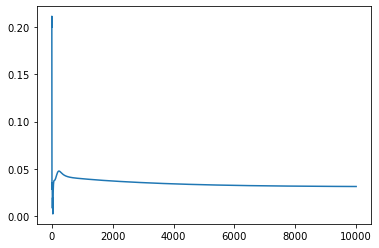

In [30]:
plt.plot(rec_errors)

In [28]:
l_weeks,l_days,l_hours = loadings = kruskal_tensor[1]

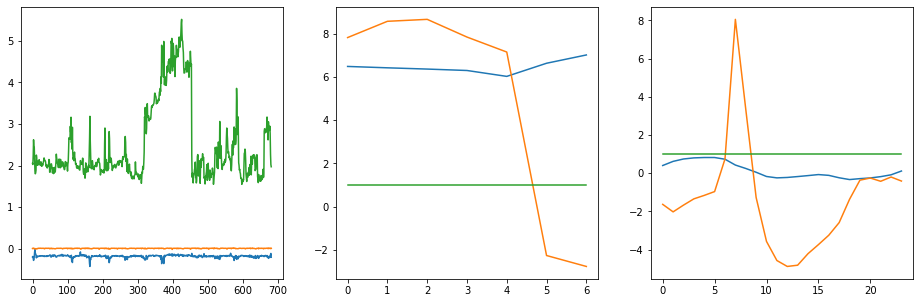

In [29]:
f,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(l_weeks)
ax[1].plot(l_days)
ax[2].plot(l_hours)
plt.show()

In [7]:
from tensorly.kruskal_tensor import khatri_rao
import numpy as np

In [13]:
# matrixes = np.array([[1,1,1],[1,1,1],[1,1,2]])
np.outer([1,1,2],[1,1,1] )

array([[1, 1, 1],
       [1, 1, 1],
       [2, 2, 2]])

# Ideas for second attempt:

### Try to remove the flat 
